In [7]:
import fastf1
from fastf1.core import Session
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import train_test_split
from keras.src.models import Sequential
from keras.src.layers import Dense, Dropout
from keras.src.regularizers import L2
import keras_tuner as kt
from keras.src.optimizers import Adam
from keras.src.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_is_fitted
from scikeras.wrappers import KerasRegressor
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import learning_curve


fastf1.Cache.enable_cache('../data')
fastf1.Cache.offline_mode(True)

In [8]:
current_date = datetime.datetime.now()

In [9]:
# Get the event schedule for 2024
schedule_2024 = fastf1.get_event_schedule(2024)

# Convert 'EventDate' to datetime if it's not already
schedule_2024['EventDate'] = pd.to_datetime(schedule_2024['EventDate'])

# Filter events that have occurred before the current date
past_events_2024 = schedule_2024[schedule_2024['EventDate'] < current_date]

# Get the first event of 2023
event_2018_r1 = fastf1.get_event(2018, 1)  # First round of 2018


In [10]:
def get_weather_data(session: Session, type: str):
    weather_data = session.laps.get_weather_data()
    weather = weather_data[['AirTemp', 'Humidity', 'TrackTemp']].mean()
    weather = weather.rename({
        'AirTemp': f'{type}_AirTemp',
        'Humidity': f'{type}_Humidity',
        'TrackTemp': f'{type}_TrackTemp'
    })
    return weather


In [11]:
def process_qualifying(session: Session):
    # Get qualifying results
    qualifying_results = session.results

    # Select and rename qualifying features
    qualifying_features = qualifying_results[['DriverNumber', 'Position']].copy()
    qualifying_features.rename(columns={'Position': 'Position_Qualifying'}, inplace=True)

    # Check for 'Q1', 'Q2', 'Q3' columns and add if missing
    for q_col in ['Q1', 'Q2', 'Q3']:
        if q_col in qualifying_results.columns:
            qualifying_features[q_col] = qualifying_results[q_col]
        else:
            qualifying_features[q_col] = pd.NaT

    # Convert lap times to total seconds
    for col in ['Q1', 'Q2', 'Q3']:
        qualifying_features[col] = qualifying_features[col].apply(
            lambda x: x.total_seconds() if isinstance(x, pd.Timedelta) else (x if isinstance(x, (float, int)) else 999)
        )

    # Get average lap times for each driver in qualifying
    qualifying_laps = session.laps
    qualifying_laps = qualifying_laps[pd.notnull(qualifying_laps['LapTime'])]

    if not qualifying_laps.empty:
        qualifying_laps = qualifying_laps.copy()
        qualifying_laps['LapTime_seconds'] = qualifying_laps['LapTime'].dt.total_seconds()
        qualifying_avg_lap_times = qualifying_laps.groupby('DriverNumber')['LapTime_seconds'].mean().reset_index()
        qualifying_avg_lap_times.rename(columns={'LapTime_seconds': 'Qualifying_AvgLapTime'}, inplace=True)
    else:
        qualifying_avg_lap_times = pd.DataFrame(columns=['DriverNumber', 'Qualifying_AvgLapTime'])

    # Merge qualifying features with average lap times
    qualifying_features['DriverNumber'] = qualifying_features['DriverNumber'].astype(str)
    qualifying_avg_lap_times['DriverNumber'] = qualifying_avg_lap_times['DriverNumber'].astype(str)
    qualifying_features = pd.merge(qualifying_features, qualifying_avg_lap_times, on='DriverNumber', how='left')

    return qualifying_features



In [12]:
def get_telemetry_data(session: Session):
    telemetry_data_list = []
    for driver in session.drivers:
        try:
            # Get laps for the driver and pick the fastest lap
            driver_laps = session.laps.pick_drivers(driver)
            fastest_lap = driver_laps.pick_fastest()
            # Get car data (speed, throttle, brake, etc.)
            car_data = driver_laps.get_car_data()
            pos_data = driver_laps.get_pos_data()

            # Aggregate car data
            avg_speed = car_data['Speed'].mean()
            max_speed = car_data['Speed'].max()
            avg_throttle = car_data['Throttle'].mean()
            avg_brake = car_data['Brake'].mean()
            avg_rpm = car_data['RPM'].mean()
            avg_gear = car_data['nGear'].mean()
            max_rpm = car_data['RPM'].max()

            # Get telemetry data for the fastest lap
            telemetry = fastest_lap.get_telemetry()
            avg_speed = telemetry['Speed'].mean()
            avg_throttle = telemetry['Throttle'].mean()
            avg_brake = telemetry['Brake'].mean()

            # Status (OnTrack/OffTrack)
            on_track_percentage = pos_data['Status'].value_counts(normalize=True).get('OnTrack', 0) * 100


            # Append telemetry data for the driver
            telemetry_data_list.append({
                'DriverNumber': driver,
                'AvgSpeed': avg_speed,
                'MaxSpeed': max_speed,
                'AvgThrottle': avg_throttle,
                'AvgBrake': avg_brake,
                'AvgRPM': avg_rpm,
                'MaxRPM': max_rpm,
                'AvgGear': avg_gear,
                'OnTrack%': on_track_percentage
            })

        except Exception as e:
            print(f"Telemetry data not available for driver {driver}: {e}")
            continue

    # Concatenate telemetry data
    telemetry_data = pd.DataFrame(telemetry_data_list)

    telemetry_data['DriverNumber'] = telemetry_data['DriverNumber'].astype(str)

    return telemetry_data

In [13]:
def process_race(session: Session):
    race_results = session.results

    # Select and rename race features
    race_features = race_results[['DriverNumber', 'Abbreviation', 'TeamName', 'GridPosition', 'Position']].copy()
    race_features.rename(columns={
        'Abbreviation': 'Abbreviation_Race',
        'TeamName': 'TeamName_Race',
        'GridPosition': 'GridPosition_Race',
        'Position': 'Position_Race'
    }, inplace=True)

    # Get average lap times for each driver in race
    race_laps = session.laps
    race_laps = race_laps[pd.notnull(race_laps['LapTime'])]

    if not race_laps.empty:
        race_laps = race_laps.copy()
        race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
        race_avg_lap_times = race_laps.groupby('DriverNumber')['LapTime_seconds'].mean().reset_index()
        race_avg_lap_times.rename(columns={'LapTime_seconds': 'Race_AvgLapTime'}, inplace=True)
    else:
        race_avg_lap_times = pd.DataFrame(columns=['DriverNumber', 'Race_AvgLapTime'])

    # Merge race features with average lap times
    race_features['DriverNumber'] = race_features['DriverNumber'].astype(str)
    race_avg_lap_times['DriverNumber'] = race_avg_lap_times['DriverNumber'].astype(str)
    race_features = pd.merge(race_features, race_avg_lap_times, on='DriverNumber', how='left')

    race_features['DriverNumber'] = race_features['DriverNumber'].astype(str)

    race_telemetry_data = get_telemetry_data(session)

    race_features = pd.merge(race_features, race_telemetry_data, on='DriverNumber', how='left')

    return race_features


In [59]:
def process_event(qualifying_session, race_session):
    # Get event name
    event_name = race_session.event['EventName']
    event_year = race_session.event['EventDate'].year

    # Load weather data for the qualifying session
    qualifying_weather = get_weather_data(qualifying_session, 'Qualifying')

    # Load weather data for the race session
    race_weather = get_weather_data(race_session, 'Race')

    # Get qualifying and race results
    qualifying_results = process_qualifying(qualifying_session)
    race_results = process_race(race_session)

    # Merge qualifying and race features
    combined_results = pd.merge(
        qualifying_results,
        race_results,
        on='DriverNumber',
        how='inner'
    )

    # Add qualifying weather data
    for col in qualifying_weather.index:
        combined_results[col] = qualifying_weather[col]

    # Add race weather data
    for col in race_weather.index:
        combined_results[col] = race_weather[col]

    # Add EventName
    combined_results['EventName'] = event_name

    # Add EventYear
    combined_results['EventYear'] = event_year
    combined_results['EventYear'] = combined_results['EventYear'].astype(str)

    # Ensure numerical columns are of correct type
    numerical_cols = [
        'Position_Qualifying', 'GridPosition_Race', 'Q1', 'Q2', 'Q3',
        'Qualifying_AvgLapTime', 'Race_AvgLapTime',
        'AvgSpeed', 'MaxSpeed', 'AvgThrottle', 'AvgBrake',
        'AvgRPM', 'MaxRPM', 'AvgGear',
        'Qualifying_AirTemp', 'Qualifying_Humidity', 'Qualifying_TrackTemp',
        'Race_AirTemp', 'Race_Humidity', 'Race_TrackTemp'
    ]

    # Only process existing columns
    existing_cols = [col for col in numerical_cols if col in combined_results.columns]

    for col in existing_cols:
        combined_results[col] = pd.to_numeric(combined_results[col], errors='coerce')

    # Fill NaN values in existing numerical columns
    combined_results[existing_cols] = combined_results[existing_cols].fillna(0)

    # Prepare the list of columns to select
    feature_cols = [
        'DriverNumber',
        'Abbreviation_Race',
        'TeamName_Race',
        'Position_Qualifying',
        'GridPosition_Race',
        'Q1',
        'Q2',
        'Q3',
        'Qualifying_AvgLapTime',
        'Race_AvgLapTime',
        'AvgSpeed',
        'MaxSpeed',
        'AvgThrottle',
        'AvgBrake',
        'AvgRPM',
        'MaxRPM',
        'AvgGear',
        'OnTrack%',
        'Qualifying_AirTemp',
        'Qualifying_Humidity',
        'Qualifying_TrackTemp',
        'Race_AirTemp',
        'Race_Humidity',
        'Race_TrackTemp',
        'EventName',
        'EventYear'
    ]

    # Only select existing columns
    existing_feature_cols = [col for col in feature_cols if col in combined_results.columns]

    # Select features
    features = combined_results[existing_feature_cols].fillna(0)

    # Get the target variable
    target = combined_results['Position_Race']

    # Return combined features and target
    return pd.concat([features, target.rename('RacePosition')], axis=1)


In [60]:
data_frames = []

# Process 2024 events
for index, event in past_events_2024.iterrows():
    print(f"Processing event: {event['EventName']}, {event['EventDate'].year}")

    try:
        # Load the qualifying session
        qualifying_session = fastf1.get_session(event['EventDate'].year, event['RoundNumber'], 'Q')
        qualifying_session.load()

        # Load the race session
        race_session = fastf1.get_session(event['EventDate'].year, event['RoundNumber'], 'R')
        race_session.load()

        # Process the event to get features and target
        event_data = process_event(qualifying_session, race_session)

        # Append to data_frames list
        data_frames.append(event_data)

    except Exception as e:
        print(f"An error occurred while processing event {event['EventName']}: {e}")


core           INFO 	Loading data for Australian Grand Prix - Qualifying [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data


core           INFO 	Processing timing data...


Processing event: Australian Grand Prix, 2019


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '5', '33', '16', '8', '20', '4', '7', '11', '27', '3', '23', '99', '26', '18', '10', '55', '63', '88']
core           INFO 	Loading data for Australian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver 16: Lap timing integrity check f

Processing event: Bahrain Grand Prix, 2019


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '5', '44', '77', '33', '20', '55', '8', '7', '4', '3', '23', '10', '11', '26', '99', '27', '18', '63', '88']
core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req        

Processing event: Chinese Grand Prix, 2019


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['77', '44', '5', '16', '33', '10', '3', '27', '20', '8', '26', '11', '7', '55', '4', '18', '63', '88', '23', '99']
core           INFO 	Loading data for Chinese Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req        

Processing event: Azerbaijan Grand Prix, 2019


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['77', '44', '5', '33', '11', '26', '4', '99', '16', '55', '3', '23', '20', '18', '8', '27', '63', '88', '7', '10']
core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req     

Processing event: Spanish Grand Prix, 2019


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['77', '44', '5', '33', '16', '10', '8', '20', '26', '3', '4', '23', '55', '7', '11', '27', '18', '99', '63', '88']
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req        

Processing event: Monaco Grand Prix, 2019


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '5', '10', '20', '3', '26', '55', '23', '27', '4', '8', '7', '99', '16', '11', '18', '63', '88']
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req         

Processing event: Canadian Grand Prix, 2019


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['5', '44', '16', '3', '10', '77', '27', '4', '55', '20', '33', '26', '99', '23', '8', '11', '7', '18', '63', '88']
core           INFO 	Loading data for Canadian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req       

Processing event: French Grand Prix, 2019


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '16', '33', '4', '55', '5', '3', '10', '99', '23', '7', '27', '11', '20', '26', '8', '18', '63', '88']
core           INFO 	Loading data for French Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver 27: Lap timing integrity check faile

Processing event: Austrian Grand Prix, 2019


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '44', '33', '77', '20', '4', '7', '99', '10', '5', '8', '27', '23', '3', '55', '11', '18', '26', '63', '88']
core           INFO 	Loading data for Austrian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req       

Processing event: British Grand Prix, 2019


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['77', '44', '16', '33', '10', '5', '3', '4', '23', '27', '99', '7', '55', '8', '11', '20', '26', '18', '63', '88']
core           INFO 	Loading data for British Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req        

Processing event: German Grand Prix, 2019


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '10', '7', '8', '55', '11', '27', '16', '99', '20', '3', '26', '18', '4', '23', '63', '88', '5']
core           INFO 	Loading data for German Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req         

Telemetry data not available for driver 11: nan
Processing event: Hungarian Grand Prix, 2019


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '77', '44', '16', '5', '10', '4', '55', '8', '7', '27', '23', '26', '99', '20', '63', '11', '3', '18', '88']
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req      

Processing event: Belgian Grand Prix, 2019


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '5', '44', '77', '33', '3', '27', '7', '11', '20', '8', '4', '18', '23', '99', '10', '55', '26', '63', '88']
core           INFO 	Loading data for Belgian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req        

Telemetry data not available for driver 55: nan
Telemetry data not available for driver 33: nan
Processing event: Italian Grand Prix, 2019


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '44', '77', '5', '3', '27', '55', '23', '18', '7', '99', '20', '26', '4', '10', '8', '11', '63', '88', '33']
core           INFO 	Loading data for Italian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req        

Processing event: Singapore Grand Prix, 2019


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '44', '5', '33', '77', '23', '55', '27', '4', '11', '99', '10', '7', '20', '26', '18', '8', '63', '88', '3']
core           INFO 	Loading data for Singapore Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver 18: Lap timing integrity check fa

Processing event: Russian Grand Prix, 2019


core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 26)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '44', '5', '33', '77', '55', '27', '4', '8', '3', '10', '11', '99', '20', '18', '7', '63', '88', '23', '26']
core           INFO 	Loading data for Russian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core    

Telemetry data not available for driver 8: nan
Processing event: Japanese Grand Prix, 2019


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['5', '16', '77', '44', '33', '23', '55', '4', '10', '8', '99', '18', '7', '26', '27', '3', '11', '63', '20', '88']
core           INFO 	Loading data for Japanese Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req       

Processing event: Mexican Grand Prix, 2019


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '16', '5', '44', '23', '77', '55', '4', '26', '10', '11', '27', '3', '7', '99', '18', '20', '8', '63', '88']
core           INFO 	Loading data for Mexican Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver  5: Lap timing integrity check fail

Processing event: United States Grand Prix, 2019


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['77', '5', '33', '16', '44', '23', '55', '4', '3', '10', '27', '20', '26', '18', '8', '99', '7', '63', '11', '88']
core           INFO 	Loading data for United States Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver  4: Lap timing integrity chec

Processing event: Brazilian Grand Prix, 2019


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '5', '44', '16', '77', '23', '10', '8', '7', '20', '4', '3', '99', '27', '11', '26', '18', '63', '88', '55']
core           INFO 	Loading data for Brazilian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver 20: Lap timing integrity check fa

Processing event: Abu Dhabi Grand Prix, 2019


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '16', '5', '23', '4', '3', '55', '27', '11', '10', '18', '26', '20', '8', '99', '7', '63', '88']
core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver  4: Lap timing integrity check fa

Processing event: Pre-Season Test 1, 2020
An error occurred while processing event Pre-Season Test 1: Cannot get testing event by round number!
Processing event: Pre-Season Test 2, 2020
An error occurred while processing event Pre-Season Test 2: Cannot get testing event by round number!
Processing event: Austrian Grand Prix, 2020


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['77', '44', '33', '4', '23', '11', '16', '55', '18', '3', '5', '10', '26', '31', '8', '20', '63', '99', '7', '6']
core           INFO 	Loading data for Austrian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver 77: Lap timing integrity check fail

Processing event: Styrian Grand Prix, 2020


/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:1579: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<TimedeltaArray>
['0 days 01:00:39.414000']
Length: 1, dtype: timedelta64[ns]' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  result.loc[mask, 'LapStartTime'] = result.loc[mask, 'PitOutTime']
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '55', '77', '31', '4', '23', '10', '3', '5', '16', '63', '18', '26', '20', '7', '11', '6', '99', '8']
core           INFO 	Loading data for Styrian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
r

Telemetry data not available for driver 5: nan
Processing event: Hungarian Grand Prix, 2020


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '18', '11', '5', '16', '33', '4', '55', '10', '3', '63', '23', '31', '6', '20', '26', '8', '99', '7']
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req       

Processing event: British Grand Prix, 2020


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '16', '4', '18', '55', '3', '31', '5', '10', '23', '27', '26', '63', '20', '99', '7', '8', '6']
core           INFO 	Loading data for British Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req         

Telemetry data not available for driver 20: nan
Telemetry data not available for driver 27: nan
Processing event: 70th Anniversary Grand Prix, 2020


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['77', '44', '27', '33', '3', '18', '10', '16', '23', '4', '31', '5', '55', '8', '63', '26', '20', '6', '99', '7']
core           INFO 	Loading data for 70th Anniversary Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req

Processing event: Spanish Grand Prix, 2020


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '11', '18', '23', '55', '4', '16', '10', '5', '26', '3', '7', '31', '20', '8', '63', '6', '99']
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req         

Processing event: Belgian Grand Prix, 2020


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '3', '23', '31', '55', '11', '18', '4', '26', '10', '16', '5', '63', '7', '8', '99', '6', '20']
core           INFO 	Loading data for Belgian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req         

Telemetry data not available for driver 55: nan
Processing event: Italian Grand Prix, 2020


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '55', '11', '33', '4', '3', '18', '23', '10', '26', '31', '16', '7', '20', '8', '5', '99', '63', '6']
core           INFO 	Loading data for Italian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req         

Processing event: Tuscan Grand Prix, 2020


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '23', '16', '11', '18', '3', '55', '31', '4', '26', '7', '5', '8', '10', '99', '63', '6', '20']
core           INFO 	Loading data for Tuscan Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req          

Telemetry data not available for driver 33: nan
Telemetry data not available for driver 10: nan
Processing event: Russian Grand Prix, 2020


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '11', '3', '55', '31', '4', '10', '23', '16', '26', '18', '63', '5', '8', '99', '20', '6', '7']
core           INFO 	Loading data for Russian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req         

Telemetry data not available for driver 55: nan
Telemetry data not available for driver 18: nan
Processing event: Eifel Grand Prix, 2020


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['77', '44', '33', '16', '23', '3', '31', '4', '11', '55', '5', '10', '26', '99', '20', '8', '63', '6', '7', '27']
core           INFO 	Loading data for Eifel Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req           

Processing event: Portuguese Grand Prix, 2020


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '16', '11', '23', '55', '4', '10', '3', '31', '18', '26', '63', '5', '7', '99', '8', '20', '6']
core           INFO 	Loading data for Portuguese Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req      

Processing event: Emilia Romagna Grand Prix, 2020


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['77', '44', '33', '10', '3', '23', '16', '26', '4', '55', '11', '31', '63', '5', '18', '8', '20', '7', '6', '99']
core           INFO 	Loading data for Emilia Romagna Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver 23: Lap timing integrity chec

Processing event: Turkish Grand Prix, 2020


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['18', '33', '11', '23', '3', '44', '31', '7', '77', '99', '4', '5', '55', '16', '10', '20', '26', '63', '8', '6']
core           INFO 	Loading data for Turkish Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req         

Processing event: Bahrain Grand Prix, 2020


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '23', '11', '3', '31', '10', '4', '26', '5', '16', '18', '63', '55', '99', '7', '20', '8', '6']
core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req         

Telemetry data not available for driver 18: nan
Telemetry data not available for driver 8: nan
Processing event: Sakhir Grand Prix, 2020


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['77', '63', '33', '16', '11', '26', '3', '55', '10', '18', '31', '23', '5', '99', '4', '20', '6', '89', '7', '51']
core           INFO 	Loading data for Sakhir Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req         

Telemetry data not available for driver 33: nan
Telemetry data not available for driver 16: nan
Processing event: Abu Dhabi Grand Prix, 2020


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '77', '44', '4', '23', '55', '26', '18', '16', '10', '31', '3', '5', '99', '11', '7', '20', '63', '51', '6']
core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver  6: Lap timing integrity check fa

Processing event: Pre-Season Test, 2021
An error occurred while processing event Pre-Season Test: Cannot get testing event by round number!
Processing event: Bahrain Grand Prix, 2021


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '77', '16', '10', '3', '4', '55', '14', '18', '11', '99', '22', '7', '63', '31', '6', '5', '47', '9']
core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req         

Telemetry data not available for driver 9: nan
Processing event: Emilia Romagna Grand Prix, 2021


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '11', '33', '16', '10', '3', '4', '77', '31', '18', '55', '63', '5', '6', '14', '7', '99', '47', '9', '22']
core           INFO 	Loading data for Emilia Romagna Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req  

Telemetry data not available for driver 6: nan
Processing event: Portuguese Grand Prix, 2021


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['77', '44', '33', '11', '55', '31', '4', '16', '10', '5', '63', '99', '14', '22', '7', '3', '18', '6', '47', '9']
core           INFO 	Loading data for Portuguese Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req      

Telemetry data not available for driver 7: nan
Processing event: Spanish Grand Prix, 2021


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '16', '31', '55', '3', '11', '4', '14', '18', '10', '5', '99', '63', '22', '7', '47', '6', '9']
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req         

Processing event: Monaco Grand Prix, 2021


core        WARNING 	No lap data for driver 47
core        WARNING 	Driver  5: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 47)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '33', '77', '55', '4', '10', '44', '5', '11', '99', '31', '3', '18', '7', '63', '22', '14', '6', '9', '47']
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req     

Telemetry data not available for driver 16: nan
Processing event: Azerbaijan Grand Prix, 2021


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '44', '33', '10', '55', '4', '11', '22', '14', '77', '5', '31', '3', '7', '63', '6', '47', '9', '18', '99']
core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req      

Processing event: French Grand Prix, 2021


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '77', '11', '55', '10', '16', '4', '14', '3', '31', '5', '99', '63', '47', '6', '7', '9', '18', '22']
core           INFO 	Loading data for French Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req          

Processing event: Styrian Grand Prix, 2021


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '77', '44', '4', '11', '10', '16', '22', '14', '18', '63', '55', '3', '5', '99', '6', '31', '7', '47', '9']
core           INFO 	Loading data for Styrian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req         

Telemetry data not available for driver 10: nan
Processing event: Austrian Grand Prix, 2021


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '4', '11', '44', '77', '10', '22', '5', '63', '18', '55', '16', '3', '14', '99', '7', '31', '6', '47', '9']
core           INFO 	Loading data for Austrian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req        

Telemetry data not available for driver 31: nan
Processing event: British Grand Prix, 2021


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '16', '11', '4', '3', '63', '55', '5', '14', '10', '31', '99', '18', '22', '7', '6', '47', '9']
core           INFO 	Loading data for British Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req         

Telemetry data not available for driver 33: nan
Processing event: Hungarian Grand Prix, 2021


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '11', '10', '4', '16', '31', '14', '5', '3', '18', '7', '99', '55', '22', '63', '6', '9', '47']
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req       

Telemetry data not available for driver 9: nan
Telemetry data not available for driver 4: nan
Telemetry data not available for driver 77: nan
Telemetry data not available for driver 11: nan
Telemetry data not available for driver 16: nan
Telemetry data not available for driver 18: nan
Processing event: Belgian Grand Prix, 2021


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '63', '44', '3', '5', '10', '11', '77', '31', '4', '16', '6', '55', '14', '18', '99', '22', '47', '7', '9']
core           INFO 	Loading data for Belgian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req         

Telemetry data not available for driver 33: nan
Telemetry data not available for driver 63: nan
Telemetry data not available for driver 44: nan
Telemetry data not available for driver 3: nan
Telemetry data not available for driver 5: nan
Telemetry data not available for driver 10: nan
Telemetry data not available for driver 31: nan
Telemetry data not available for driver 16: nan
Telemetry data not available for driver 6: nan
Telemetry data not available for driver 55: nan
Telemetry data not available for driver 14: nan
Telemetry data not available for driver 77: nan
Telemetry data not available for driver 99: nan
Telemetry data not available for driver 4: nan
Telemetry data not available for driver 22: nan
Telemetry data not available for driver 47: nan
Telemetry data not available for driver 9: nan
Telemetry data not available for driver 7: nan
Telemetry data not available for driver 11: nan
Telemetry data not available for driver 18: nan
An error occurred while processing event Belgi

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '77', '10', '16', '55', '99', '31', '14', '3', '63', '18', '4', '6', '22', '11', '5', '88', '47', '9']
core           INFO 	Loading data for Dutch Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req          

Processing event: Italian Grand Prix, 2021


core        WARNING 	Driver 16: Lap timing integrity check failed for 1 lap(s)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['77', '44', '33', '4', '3', '10', '55', '16', '11', '99', '5', '18', '14', '31', '63', '6', '22', '47', '88', '9']
core           INFO 	Loading data for Italian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing

Telemetry data not available for driver 22: nan
Processing event: Russian Grand Prix, 2021


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '55', '63', '44', '3', '14', '77', '18', '11', '31', '5', '10', '22', '6', '16', '7', '47', '99', '9', '33']
core           INFO 	Loading data for Russian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req         

Processing event: Turkish Grand Prix, 2021


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '16', '10', '14', '11', '4', '18', '22', '5', '31', '63', '47', '55', '3', '6', '99', '7', '9']
core           INFO 	Loading data for Turkish Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req         

Processing event: United States Grand Prix, 2021


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '11', '77', '16', '55', '3', '4', '10', '22', '31', '5', '99', '14', '63', '18', '6', '7', '47', '9']
core           INFO 	Loading data for United States Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver  7: Lap timing integrity check

Processing event: Mexico City Grand Prix, 2021


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['77', '44', '33', '11', '10', '55', '3', '16', '22', '4', '5', '7', '63', '99', '31', '14', '6', '47', '9', '18']
core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req     

Telemetry data not available for driver 47: nan
Telemetry data not available for driver 22: nan
Processing event: São Paulo Grand Prix, 2021


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '11', '10', '55', '16', '4', '3', '14', '31', '5', '22', '7', '99', '18', '6', '63', '47', '9']
core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req       

Processing event: Qatar Grand Prix, 2021


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '10', '14', '4', '55', '22', '31', '5', '11', '18', '16', '3', '63', '7', '6', '99', '47', '9']
core           INFO 	Loading data for Qatar Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req           

Processing event: Saudi Arabian Grand Prix, 2021


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '16', '11', '10', '4', '22', '31', '99', '3', '7', '14', '63', '55', '6', '5', '18', '47', '9']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req   

Processing event: Abu Dhabi Grand Prix, 2021


core        WARNING 	Driver 22: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver  3: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 18: Lap timing integrity check failed for 1 lap(s)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '4', '11', '55', '77', '16', '22', '31', '3', '14', '10', '18', '99', '5', '6', '63', '7', '47', '9']
core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_d

Telemetry data not available for driver 9: Cannot slice telemetry because self contains no driver number!
Processing event: Pre-Season Track Session, 2022
An error occurred while processing event Pre-Season Track Session: Cannot get testing event by round number!
Processing event: Pre-Season Test, 2022
An error occurred while processing event Pre-Season Test: Cannot get testing event by round number!
Processing event: Bahrain Grand Prix, 2022


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '1', '55', '11', '44', '77', '20', '14', '63', '10', '31', '47', '4', '23', '24', '22', '27', '3', '18', '6']
core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req       

Processing event: Saudi Arabian Grand Prix, 2022


core        WARNING 	Driver 18: Lap timing integrity check failed for 1 lap(s)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '16', '55', '1', '31', '63', '14', '77', '10', '20', '4', '3', '24', '47', '18', '44', '23', '27', '6', '22']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Pro

Telemetry data not available for driver 22: Cannot slice telemetry because self contains no driver number!
Telemetry data not available for driver 47: Cannot slice telemetry because self contains no driver number!
Processing event: Australian Grand Prix, 2022


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '1', '11', '4', '44', '63', '3', '31', '55', '14', '10', '77', '22', '24', '47', '23', '20', '5', '6', '18']
core           INFO 	Loading data for Australian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req     

Telemetry data not available for driver 55: nan
Processing event: Emilia Romagna Grand Prix, 2022


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '4', '20', '14', '3', '11', '77', '5', '55', '63', '47', '44', '24', '18', '22', '10', '6', '31', '23']
core           INFO 	Loading data for Emilia Romagna Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req 

Telemetry data not available for driver 55: nan
Processing event: Miami Grand Prix, 2022


core        WARNING 	No lap data for driver 31
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 31)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '55', '1', '11', '77', '44', '10', '4', '22', '18', '14', '63', '5', '3', '47', '20', '24', '23', '6', '31']
core           INFO 	Loading data for Miami Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	U

Processing event: Spanish Grand Prix, 2022


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '1', '55', '63', '11', '44', '77', '20', '3', '47', '4', '31', '22', '10', '24', '5', '14', '18', '23', '6']
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req        

Processing event: Monaco Grand Prix, 2022


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '55', '11', '1', '4', '63', '14', '44', '5', '31', '22', '77', '20', '3', '47', '23', '10', '18', '6', '24']
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req         

Processing event: Azerbaijan Grand Prix, 2022


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '11', '1', '55', '63', '10', '44', '22', '5', '14', '4', '3', '31', '24', '77', '20', '23', '6', '18', '47']
core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver 16: Lap timing integrity check f

Processing event: Canadian Grand Prix, 2022


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '14', '55', '44', '20', '47', '31', '63', '3', '24', '77', '23', '11', '4', '16', '10', '5', '18', '6', '22']
core           INFO 	Loading data for Canadian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req       

Processing event: British Grand Prix, 2022


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '1', '16', '11', '44', '4', '14', '63', '24', '6', '10', '77', '22', '3', '31', '23', '20', '5', '47', '18']
core           INFO 	Loading data for British Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req        

Telemetry data not available for driver 63: nan
Telemetry data not available for driver 24: nan
Telemetry data not available for driver 23: nan
Processing event: Austrian Grand Prix, 2022


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '55', '63', '31', '20', '47', '14', '44', '10', '23', '77', '11', '22', '4', '3', '18', '24', '6', '5']
core           INFO 	Loading data for Austrian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req       

Processing event: French Grand Prix, 2022


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '1', '11', '44', '4', '63', '14', '22', '55', '20', '3', '31', '77', '5', '23', '10', '18', '24', '47', '6']
core           INFO 	Loading data for French Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req         

Processing event: Hungarian Grand Prix, 2022


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['63', '55', '16', '4', '31', '14', '44', '77', '3', '1', '11', '24', '20', '18', '47', '22', '23', '5', '10', '6']
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req      

Processing event: Belgian Grand Prix, 2022


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '55', '11', '16', '31', '14', '44', '63', '23', '4', '3', '10', '24', '18', '47', '5', '6', '20', '22', '77']
core           INFO 	Loading data for Belgian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req        

Telemetry data not available for driver 77: nan
Telemetry data not available for driver 44: nan
Processing event: Dutch Grand Prix, 2022


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '55', '44', '11', '63', '4', '47', '22', '18', '10', '31', '14', '24', '23', '77', '3', '20', '5', '6']
core           INFO 	Loading data for Dutch Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req          

Processing event: Italian Grand Prix, 2022


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '1', '55', '11', '44', '63', '4', '3', '10', '14', '31', '77', '45', '24', '22', '6', '5', '18', '20', '47']
core           INFO 	Loading data for Italian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req        

Processing event: Singapore Grand Prix, 2022


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '11', '44', '55', '14', '4', '10', '1', '20', '22', '63', '18', '47', '5', '24', '77', '3', '31', '23', '6']
core           INFO 	Loading data for Singapore Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req      

Processing event: Japanese Grand Prix, 2022


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '55', '11', '31', '44', '14', '63', '5', '4', '3', '77', '22', '24', '47', '23', '10', '20', '18', '6']
core           INFO 	Loading data for Japanese Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req       

Telemetry data not available for driver 55: nan
Telemetry data not available for driver 23: nan
Processing event: United States Grand Prix, 2022


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '16', '1', '11', '44', '63', '18', '4', '14', '77', '23', '5', '10', '24', '22', '20', '3', '31', '47', '6']
core           INFO 	Loading data for United States Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req  

Telemetry data not available for driver 55: nan
Processing event: Mexico City Grand Prix, 2022


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '63', '44', '11', '55', '77', '16', '4', '14', '31', '3', '24', '22', '10', '20', '47', '5', '18', '23', '6']
core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req    

Processing event: São Paulo Grand Prix, 2022


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['20', '1', '63', '4', '55', '31', '14', '44', '11', '16', '23', '10', '5', '3', '18', '6', '24', '77', '22', '47']
core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req      

Telemetry data not available for driver 20: nan
Telemetry data not available for driver 3: nan
Processing event: Abu Dhabi Grand Prix, 2022


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '55', '44', '63', '4', '31', '5', '3', '14', '22', '47', '18', '24', '20', '10', '77', '23', '6']
core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
logger      WARNING 	Failed to add first lap time from Ergast

Processing event: Pre-Season Testing, 2023
An error occurred while processing event Pre-Season Testing: Cannot get testing event by round number!
Processing event: Bahrain Grand Prix, 2023


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '55', '14', '63', '44', '18', '31', '27', '4', '77', '24', '22', '23', '2', '20', '81', '21', '10']
core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req      

Processing event: Saudi Arabian Grand Prix, 2023


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '16', '14', '63', '55', '18', '31', '44', '81', '10', '27', '24', '20', '77', '1', '22', '23', '21', '4', '2']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req

Processing event: Australian Grand Prix, 2023


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '63', '44', '14', '55', '18', '16', '23', '10', '27', '31', '22', '4', '20', '21', '81', '24', '2', '77', '11']
core           INFO 	Loading data for Australian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req   

Telemetry data not available for driver 16: nan
Processing event: Azerbaijan Grand Prix, 2023


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '1', '11', '55', '44', '14', '4', '22', '18', '81', '63', '31', '23', '77', '2', '24', '27', '20', '10', '21']
core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req   

Processing event: Miami Grand Prix, 2023


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '14', '55', '20', '10', '63', '16', '31', '1', '77', '23', '27', '44', '24', '21', '4', '22', '18', '81', '2']
core           INFO 	Loading data for Miami Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_

Processing event: Monaco Grand Prix, 2023


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '14', '16', '31', '55', '44', '10', '63', '22', '4', '81', '21', '23', '18', '77', '2', '20', '27', '24', '11']
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req       

Processing event: Spanish Grand Prix, 2023


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '55', '4', '10', '44', '18', '31', '27', '14', '81', '11', '63', '24', '21', '22', '77', '20', '23', '16', '2']
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req      

Processing event: Canadian Grand Prix, 2023


core        WARNING 	Driver  1: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 55: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 11: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver  2: Lap timing integrity check failed for 1 lap(s)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '27', '14', '44', '63', '31', '4', '55', '81', '23', '16', '11', '18', '20', '77', '22', '10', '21', '2', '24']
core           INFO 	Loading data for Canadian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using ca

Processing event: Austrian Grand Prix, 2023


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '55', '4', '44', '18', '14', '27', '10', '23', '63', '31', '81', '77', '11', '22', '24', '2', '20', '21']
core           INFO 	Loading data for Austrian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req     

Processing event: British Grand Prix, 2023


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '16', '55', '63', '44', '23', '14', '10', '27', '18', '31', '2', '77', '11', '22', '24', '21', '20']
core           INFO 	Loading data for British Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req      

Processing event: Hungarian Grand Prix, 2023


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '1', '4', '81', '24', '16', '77', '14', '11', '27', '55', '31', '3', '18', '10', '23', '22', '63', '20', '2']
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req     

Telemetry data not available for driver 31: nan
Telemetry data not available for driver 10: nan
Processing event: Belgian Grand Prix, 2023


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '11', '44', '55', '81', '4', '63', '14', '18', '22', '10', '20', '77', '31', '23', '24', '2', '3', '27']
core           INFO 	Loading data for Belgian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req       

Telemetry data not available for driver 81: nan
Processing event: Dutch Grand Prix, 2023


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '63', '23', '14', '55', '11', '81', '16', '2', '18', '10', '44', '22', '27', '24', '31', '20', '77', '40']
core           INFO 	Loading data for Dutch Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req        

Processing event: Italian Grand Prix, 2023


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '1', '16', '63', '11', '23', '81', '44', '4', '14', '22', '40', '27', '77', '2', '24', '10', '31', '20', '18']
core           INFO 	Loading data for Italian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req      

Telemetry data not available for driver 22: nan
Processing event: Singapore Grand Prix, 2023


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '63', '16', '4', '44', '20', '14', '31', '27', '40', '1', '10', '11', '23', '22', '77', '81', '2', '24', '18']
core           INFO 	Loading data for Singapore Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 18
core        

Telemetry data not available for driver 22: nan
Telemetry data not available for driver 18: Cannot slice telemetry because self contains no driver number!
Processing event: Japanese Grand Prix, 2023


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '81', '4', '16', '11', '55', '44', '63', '22', '14', '40', '10', '23', '31', '20', '77', '18', '27', '24', '2']
core           INFO 	Loading data for Japanese Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req     

Processing event: Qatar Grand Prix, 2023


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '63', '44', '14', '16', '81', '10', '31', '77', '4', '22', '55', '11', '23', '27', '2', '18', '40', '20', '24']
core           INFO 	Loading data for Qatar Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 55
core        WARN

Telemetry data not available for driver 44: nan
Telemetry data not available for driver 55: Cannot slice telemetry because self contains no driver number!
Processing event: United States Grand Prix, 2023


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '4', '44', '55', '63', '1', '10', '31', '11', '81', '22', '24', '77', '20', '3', '27', '14', '23', '18', '2']
core           INFO 	Loading data for United States Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req 

Processing event: Mexico City Grand Prix, 2023


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '55', '1', '3', '11', '44', '81', '63', '77', '24', '10', '27', '14', '23', '22', '31', '20', '18', '4', '2']
core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req   

Telemetry data not available for driver 11: nan
Processing event: São Paulo Grand Prix, 2023


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '18', '14', '44', '63', '4', '55', '11', '81', '27', '31', '10', '20', '23', '22', '3', '77', '2', '24']
core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req     

Telemetry data not available for driver 20: nan
Telemetry data not available for driver 23: nan
Telemetry data not available for driver 16: nan
Processing event: Las Vegas Grand Prix, 2023


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '55', '1', '63', '10', '23', '2', '77', '20', '14', '44', '11', '27', '18', '3', '4', '31', '24', '81', '22']
core           INFO 	Loading data for Las Vegas Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req     

Processing event: Abu Dhabi Grand Prix, 2023


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '81', '63', '4', '22', '14', '27', '11', '10', '44', '31', '18', '23', '3', '55', '20', '77', '24', '2']
core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req     

Processing event: Pre-Season Testing, 2024
An error occurred while processing event Pre-Season Testing: Cannot get testing event by round number!
Processing event: Bahrain Grand Prix, 2024


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '63', '55', '11', '14', '4', '81', '44', '27', '22', '18', '23', '3', '20', '77', '24', '2', '31', '10']
core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req       

Processing event: Saudi Arabian Grand Prix, 2024


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '11', '14', '81', '4', '63', '44', '22', '18', '38', '23', '20', '3', '27', '77', '31', '10', '2', '24']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req 

Telemetry data not available for driver 10: nan
Processing event: Australian Grand Prix, 2024


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 19 drivers: ['1', '55', '11', '4', '16', '81', '63', '22', '18', '14', '44', '23', '77', '20', '31', '27', '10', '3', '24']
core           INFO 	Loading data for Australian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req         

Processing event: Japanese Grand Prix, 2024


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '4', '55', '14', '81', '44', '16', '63', '22', '3', '27', '77', '23', '31', '18', '10', '20', '2', '24']
core           INFO 	Loading data for Japanese Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req      

Telemetry data not available for driver 3: nan
Telemetry data not available for driver 23: nan
Processing event: Chinese Grand Prix, 2024


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '4', '81', '16', '55', '63', '27', '77', '18', '3', '31', '23', '10', '24', '20', '44', '22', '2']
core           INFO 	Loading data for Chinese Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req       

Processing event: Miami Grand Prix, 2024


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '55', '11', '4', '81', '63', '44', '27', '22', '18', '10', '31', '23', '14', '77', '2', '3', '20', '24']
core           INFO 	Loading data for Miami Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req         

Processing event: Emilia Romagna Grand Prix, 2024


core        WARNING 	Driver  2: Lap timing integrity check failed for 1 lap(s)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '81', '4', '16', '55', '63', '22', '44', '3', '27', '11', '31', '18', '23', '10', '77', '24', '20', '14', '2']
core           INFO 	Loading data for Emilia Romagna Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Pr

Processing event: Monaco Grand Prix, 2024


core        WARNING 	Driver  3: Lap timing integrity check failed for 1 lap(s)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '55', '4', '63', '1', '44', '22', '23', '10', '31', '27', '3', '18', '20', '14', '2', '11', '77', '24']
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing

Telemetry data not available for driver 31: nan
Telemetry data not available for driver 11: nan
Telemetry data not available for driver 27: nan
Telemetry data not available for driver 20: nan
Processing event: Canadian Grand Prix, 2024


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['63', '1', '4', '81', '3', '14', '44', '22', '18', '23', '16', '55', '2', '20', '10', '11', '77', '31', '27', '24']
core           INFO 	Loading data for Canadian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req      

Processing event: Spanish Grand Prix, 2024


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '44', '63', '16', '55', '10', '11', '31', '81', '14', '77', '27', '18', '24', '20', '22', '3', '23', '2']
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req       

Processing event: Austrian Grand Prix, 2024


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '63', '55', '44', '16', '81', '11', '27', '31', '3', '20', '10', '22', '14', '23', '18', '77', '2', '24']
core           INFO 	Loading data for Austrian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req      

Processing event: British Grand Prix, 2024


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['63', '44', '4', '1', '81', '27', '55', '18', '23', '14', '16', '2', '22', '24', '3', '77', '20', '31', '11', '10']
core           INFO 	Loading data for British Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req       

Telemetry data not available for driver 10: nan
Processing event: Hungarian Grand Prix, 2024


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '81', '1', '55', '44', '16', '14', '18', '3', '22', '27', '77', '23', '2', '20', '11', '63', '24', '31', '10']
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req     

Processing event: Belgian Grand Prix, 2024


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '11', '44', '4', '81', '63', '55', '14', '31', '23', '10', '3', '77', '18', '27', '20', '22', '2', '24']
core           INFO 	Loading data for Belgian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req       

Processing event: Dutch Grand Prix, 2024


core        WARNING 	No lap data for driver 2
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 2)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '81', '63', '11', '16', '14', '18', '10', '55', '44', '22', '27', '20', '3', '31', '77', '24', '23', '2']
core           INFO 	Loading data for Dutch Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Us

Processing event: Italian Grand Prix, 2024


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '81', '63', '16', '55', '44', '1', '11', '23', '27', '14', '3', '20', '10', '31', '22', '18', '43', '77', '24']
core           INFO 	Loading data for Italian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req      

Processing event: Azerbaijan Grand Prix, 2024


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '55', '11', '63', '1', '44', '14', '43', '23', '50', '22', '27', '18', '3', '4', '77', '24', '31', '10']
core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req   

Processing event: Singapore Grand Prix, 2024


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '44', '63', '81', '27', '14', '22', '16', '55', '23', '43', '11', '20', '31', '3', '18', '10', '77', '24']
core           INFO 	Loading data for Singapore Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req    

Processing event: United States Grand Prix, 2024


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '55', '16', '81', '63', '10', '14', '20', '11', '22', '27', '31', '18', '30', '23', '43', '77', '44', '24']
core           INFO 	Loading data for United States Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
re

Telemetry data not available for driver 44: nan
Processing event: Mexico City Grand Prix, 2024


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '1', '4', '16', '63', '44', '20', '10', '23', '27', '22', '30', '14', '18', '77', '43', '81', '11', '31', '24']
core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req 

Telemetry data not available for driver 23: nan
Telemetry data not available for driver 22: nan
Processing event: São Paulo Grand Prix, 2024


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '63', '22', '31', '30', '16', '23', '81', '14', '18', '77', '1', '11', '55', '10', '44', '50', '43', '27', '24']
core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 23
core       

Telemetry data not available for driver 23: Cannot slice telemetry because self contains no driver number!
Telemetry data not available for driver 18: nan


In [87]:
# Concatenate all data frames
full_data = pd.concat(data_frames, ignore_index=True)

In [88]:
full_data.to_csv('full_data_all.csv', index=False)

full_data.head()

DriverNumber Abbreviation_Race    TeamName_Race  Position_Qualifying  \
0           44               HAM         Mercedes                  1.0   
1           77               BOT         Mercedes                  2.0   
2            5               VET          Ferrari                  3.0   
3           33               VER  Red Bull Racing                  4.0   
4           16               LEC          Ferrari                  5.0   

   GridPosition_Race      Q1      Q2      Q3  Qualifying_AvgLapTime  \
0                1.0  82.043  81.014  80.486              99.887000   
1                2.0  82.367  81.193  80.598             102.112643   
2                3.0  82.885  81.912  81.190             102.006364   
3                4.0  82.876  81.678  81.320              99.378250   
4                5.0  82.017  81.739  81.442              98.392417   

   Race_AvgLapTime  ...   OnTrack%  Qualifying_AirTemp  Qualifying_Humidity  \
0        88.762259  ...  99.832679           23.064835            69.580586   
1        88.402155  ...  99.837785           23.064835            69.580586   
2        89.386793  ...  99.833849           23.064835            69.580586   
3        88.790431  ...  99.826960           23.064835            69.580586   
4        89.406121  ...  99.828149           23.064835            69.580586   

   Qualifying_TrackTemp  Race_AirTemp  Race_Humidity  Race_TrackTemp  \
0              37.59011     23.344861      70.776081       40.432853   
1              37.59011     23.344861      70.776081       40.432853   
2              37.59011     23.344861      70.776081       40.432853   
3              37.59011     23.344861      70.776081       40.432853   
4              37.59011     23.344861      70.776081       40.432853   

               EventName  EventYear  RacePosition  
0  Australian Grand Prix       2019           2.0  
1  Australian Grand Prix       2019           1.0  
2  Australian Grand Prix       2019           4.0  
3  Australian Grand Prix       2019           3.0  
4  Australian Grand Prix       2019           5.0  

[5 rows x 27 columns]

In [110]:
data_2024 = pd.read_csv('full_data.csv')

data_2024.columns

Index(['DriverNumber', 'Abbreviation_Race', 'TeamName_Race',
       'Position_Qualifying', 'GridPosition_Race', 'Q1', 'Q2', 'Q3',
       'Qualifying_AvgLapTime', 'Race_AvgLapTime', 'AvgSpeed', 'MaxSpeed',
       'AvgThrottle', 'AvgBrake', 'AvgRPM', 'MaxRPM', 'AvgGear', 'OnTrack%',
       'Qualifying_AirTemp', 'Qualifying_Humidity', 'Qualifying_TrackTemp',
       'Race_AirTemp', 'Race_Humidity', 'Race_TrackTemp', 'EventName',
       'RacePosition'],
      dtype='object')

In [111]:
# Define features and target variable
X_2024 = data_2024.drop(columns=['RacePosition', 'DriverNumber', 'Abbreviation_Race'])
y_2024 = data_2024['RacePosition']

In [112]:
# Define features and target variable
X = full_data.drop(columns=['RacePosition', 'DriverNumber', 'Abbreviation_Race'])
y = full_data['RacePosition']

In [116]:
numerical_features = [
    'Position_Qualifying', 'GridPosition_Race', 'Q1', 'Q2', 'Q3',
    'Qualifying_AvgLapTime', 'Race_AvgLapTime',
    'AvgSpeed', 'MaxSpeed', 'AvgThrottle', 'AvgBrake',
    'AvgRPM', 'MaxRPM', 'AvgGear', 'OnTrack%',
    'Qualifying_AirTemp', 'Qualifying_Humidity', 'Qualifying_TrackTemp',
    'Race_AirTemp', 'Race_Humidity', 'Race_TrackTemp'
]

# categorical_features = ['TeamName_Race', 'EventName', 'EventYear']
categorical_features = ['TeamName_Race', 'EventName']

In [117]:
# Preprocessing for numerical data
numerical_transformer = StandardScaler()

# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [125]:
# Define the groups based on 'EventName' and 'EventYear'
# groups = full_data['EventName'] + '_' + full_data['EventYear'].astype(str)
groups = full_data['EventName']

# Initialize GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Split the data
train_idx, test_idx = next(gss.split(X, y, groups=groups))

# Create the training and test sets
X_train = X.iloc[train_idx]
X_test = X.iloc[test_idx]
y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]

In [126]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [127]:
# Fit the preprocessor on the training data
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['Position_Qualifying', 'GridPosition_Race',
                                  'Q1', 'Q2', 'Q3', 'Qualifying_AvgLapTime',
                                  'Race_AvgLapTime', 'AvgSpeed', 'MaxSpeed',
                                  'AvgThrottle', 'AvgBrake', 'AvgRPM', 'MaxRPM',
                                  'AvgGear', 'OnTrack%', 'Qualifying_AirTemp',
                                  'Qualifying_Humidity', 'Qualifying_TrackTemp',
                                  'Race_AirTemp', 'Race_Humidity',
                                  'Race_TrackTemp']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['TeamName_Race', 'EventName'])])

In [128]:
# Transform the training and test data
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [130]:
def build_model(hp):
    model = Sequential()

    # Tune the number of layers and units
    for i in range(hp.Int('num_layers', 1, 4)):
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32),
            activation='relu',
            kernel_regularizer=L2(hp.Float('l2', 1e-5, 1e-2, sampling='log'))
        ))
        # Tune dropout rate
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', 0.0, 0.5, step=0.1)))

    model.add(Dense(1))  # Output layer for regression

    # Tune the learning rate
    model.compile(
        optimizer=Adam(
            learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
        ),
        loss='mean_squared_error',
        metrics=['mae']
    )

    return model


tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=20,  # Number of hyperparameter combinations to try
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='race_outcome_prediction_v4'
)

tuner.search(
    X_train_processed, y_train,
    epochs=50,
    validation_data=(X_test_processed, y_test),
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.
Optimal number of layers: {best_hps.get('num_layers')}
""")

for i in range(best_hps.get('num_layers')):
    print(f"Units in layer {i}: {best_hps.get(f'units_{i}')}")
    print(f"Dropout rate in layer {i}: {best_hps.get(f'dropout_{i}')}")

print(f"Optimal learning rate: {best_hps.get('learning_rate')}")
print(f"Optimal L2 regularization: {best_hps.get('l2')}")

Trial 2 Complete [00h 00m 01s]
val_mae: nan

Best val_mae So Far: nan
Total elapsed time: 00h 00m 02s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
3                 |2                 |num_layers
192               |352               |units_0
0.0052702         |0.0027839         |l2
0.4               |0.2               |dropout_0
0.0015147         |0.0015002         |learning_rate
256               |32                |units_1
0.2               |0                 |dropout_1
96                |None              |units_2
0.2               |None              |dropout_2
32                |None              |units_3
0                 |None              |dropout_3

Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - loss: nan - mae: nan - val_loss: na

/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/keras_tuner/src/engine/metrics_tracking.py:111: RuntimeWarning: All-NaN axis encountered
  np.nanmin(values) if self.direction == "min" else np.nanmax(values)


RuntimeError: Number of consecutive failures exceeded the limit of 3.


In [71]:
model = tuner.hypermodel.build(best_hps)

In [72]:
history = model.fit(
    X_train_processed, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_processed, y_test),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/100


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan


In [73]:
test_loss, test_mae = model.evaluate(X_test_processed, y_test)
print(f"Test MAE after hyperparameter tuning: {test_mae}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: nan - mae: nan
Test MAE after hyperparameter tuning: nan


In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = model.predict(X_test_processed).flatten()

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error after tuning: {mae}")
print(f"Mean Squared Error after tuning: {mse}")
print(f"R2 Score after tuning: {r2}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ValueError: Input contains NaN.

In [30]:
tuner_v2 = kt.BayesianOptimization(
    build_model,
    objective='val_mae',
    max_trials=20,
    directory='hyperparam_tuning',
    project_name='race_outcome_prediction_bayesian'
)

tuner_v2.search(
    X_train_processed, y_train,
    epochs=50,
    validation_data=(X_test_processed, y_test),
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

best_hps_v2 = tuner_v2.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.
Optimal number of layers: {best_hps_v2.get('num_layers')}
""")

for i in range(best_hps_v2.get('num_layers')):
    print(f"Units in layer {i}: {best_hps_v2.get(f'units_{i}')}")
    print(f"Dropout rate in layer {i}: {best_hps_v2.get(f'dropout_{i}')}")

print(f"Optimal learning rate: {best_hps_v2.get('learning_rate')}")
print(f"Optimal L2 regularization: {best_hps_v2.get('l2')}")

Reloading Tuner from hyperparam_tuning/race_outcome_prediction_bayesian/tuner0.json

The hyperparameter search is complete.
Optimal number of layers: 3

Units in layer 0: 320
Dropout rate in layer 0: 0.30000000000000004
Units in layer 1: 224
Dropout rate in layer 1: 0.30000000000000004
Units in layer 2: 416
Dropout rate in layer 2: 0.0
Optimal learning rate: 0.00018527050551082463
Optimal L2 regularization: 0.001452008626146579


In [31]:
model_v2 = tuner_v2.hypermodel.build(best_hps_v2)

In [32]:
history_v2 = model_v2.fit(
    X_train_processed, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_processed, y_test),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan


In [33]:
test_loss_v2, test_mae_v2 = model_v2.evaluate(X_test_processed, y_test)
print(f"Test MAE after hyperparameter tuning: {test_mae_v2}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan - mae: nan
Test MAE after hyperparameter tuning: nan


In [34]:
y_pred_v2 = model_v2.predict(X_test_processed).flatten()

mae_v2 = mean_absolute_error(y_test, y_pred_v2)
mse_v2 = mean_squared_error(y_test, y_pred_v2)
r2_v2 = r2_score(y_test, y_pred_v2)

print(f"Mean Absolute Error after tuning: {mae_v2}")
print(f"Mean Squared Error after tuning: {mse_v2}")
print(f"R2 Score after tuning: {r2_v2}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ValueError: Input contains NaN.

In [35]:
# Save the model
model.save('race_outcome_model_2.keras')
model_v2.save('race_outcome_model_2_v2.keras')


In [36]:
import joblib

# Save the preprocessor
joblib.dump(preprocessor, 'preprocessor_2.joblib')


['preprocessor_2.joblib']

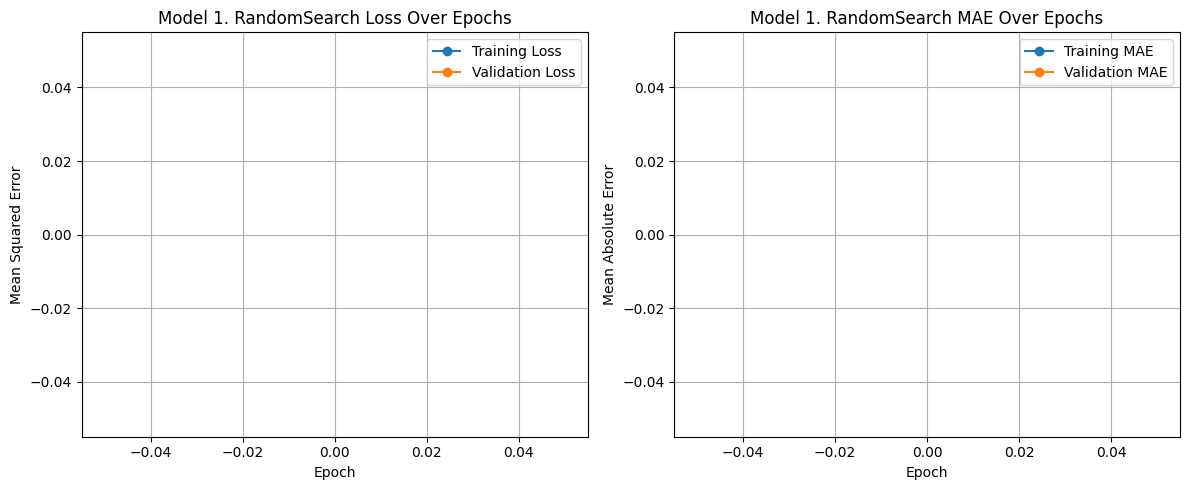

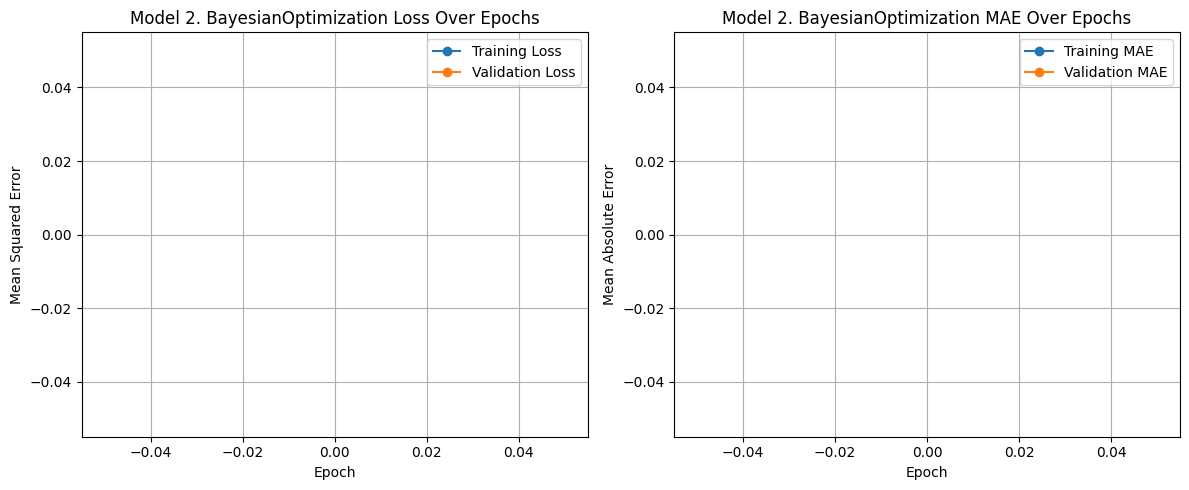

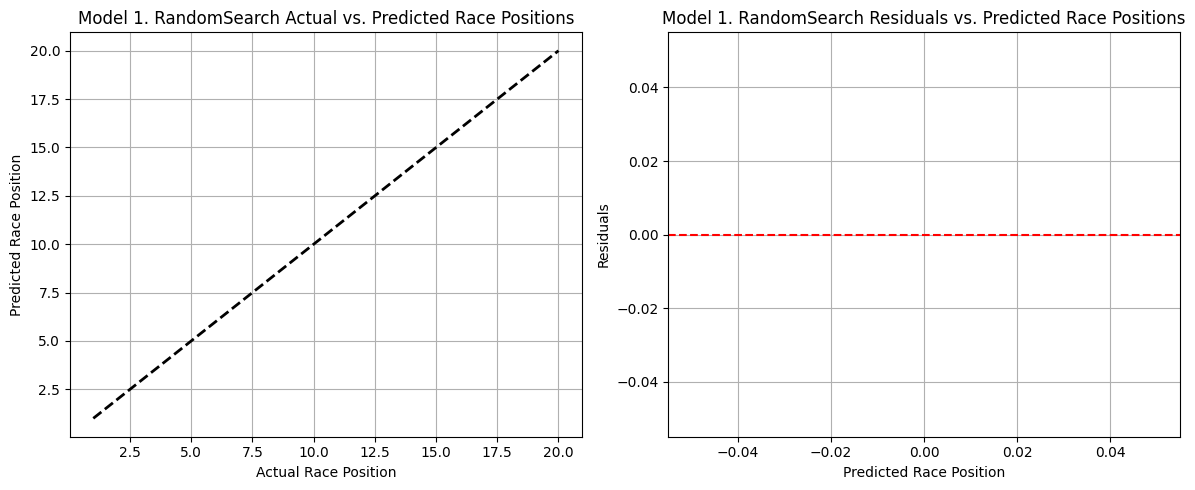

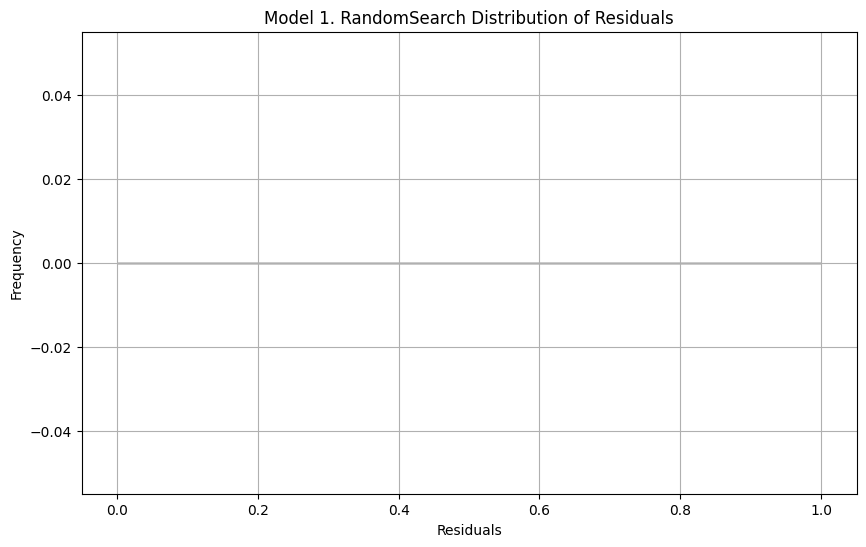

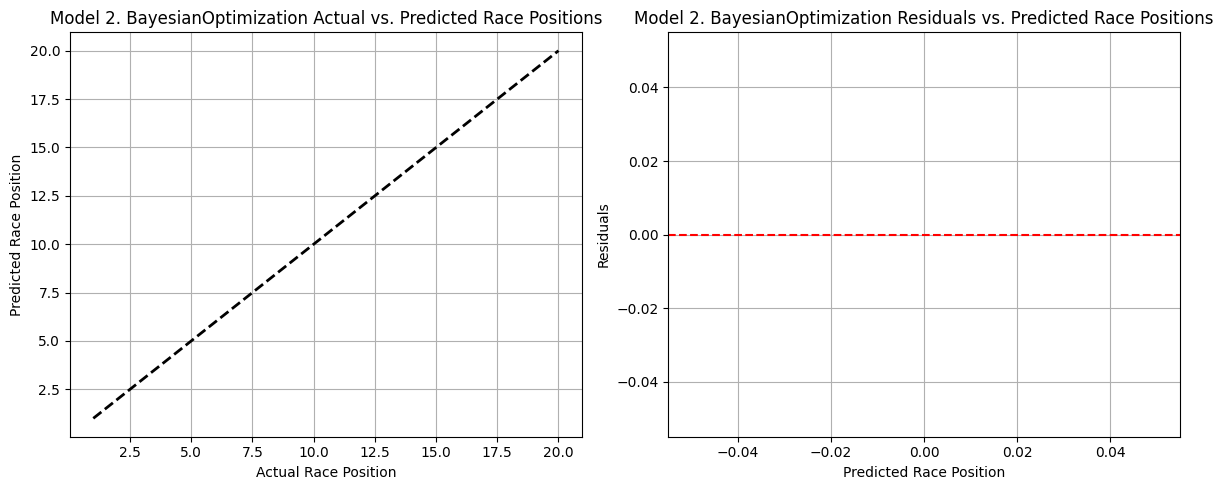

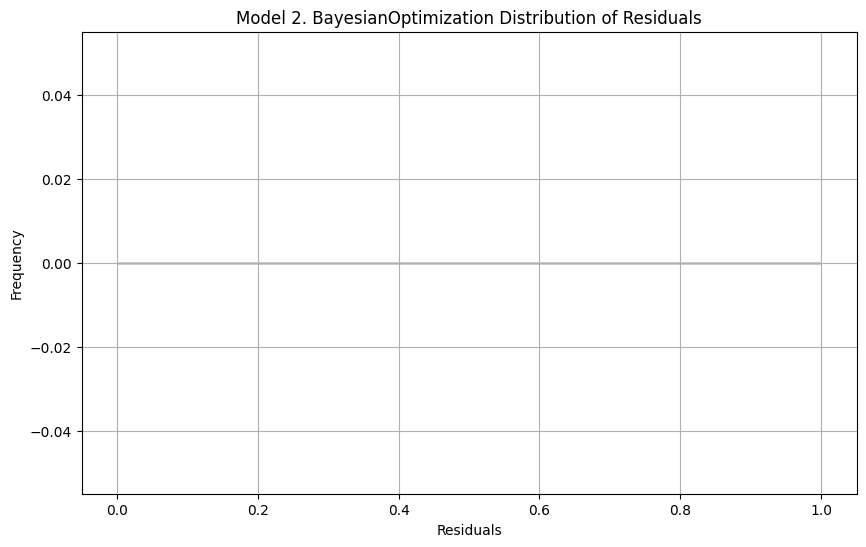

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_training_history(history, model_name):
    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title(f'{model_name} Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True)

    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE', marker='o')
    plt.plot(history.history['val_mae'], label='Validation MAE', marker='o')
    plt.title(f'{model_name} MAE Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_predictions(y_test, y_pred, model_name):
    # Actual vs. Predicted
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.title(f'{model_name} Actual vs. Predicted Race Positions')
    plt.xlabel('Actual Race Position')
    plt.ylabel('Predicted Race Position')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.grid(True)

    # Residuals
    residuals = y_test - y_pred
    plt.subplot(1, 2, 2)
    plt.scatter(y_pred, residuals, alpha=0.7)
    plt.title(f'{model_name} Residuals vs. Predicted Race Positions')
    plt.xlabel('Predicted Race Position')
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Distribution of Residuals
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title(f'{model_name} Distribution of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Use the functions
plot_training_history(history, 'Model 1. RandomSearch')
plot_training_history(history_v2, 'Model 2. BayesianOptimization')
plot_predictions(y_test, y_pred, 'Model 1. RandomSearch')
plot_predictions(y_test, y_pred_v2, 'Model 2. BayesianOptimization')


In [38]:
class KerasRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        self.model = model
        self._estimator_type = 'regressor'  # Indicate that this is a regressor

    def fit(self, X, y):
        # Since the model is already trained, we don't need to fit it again
        # However, we need to set n_features_in_ for scikit-learn compatibility
        self.n_features_in_ = X.shape[1]
        return self

    def predict(self, X):
        check_is_fitted(self, 'n_features_in_')
        return self.model.predict(X).flatten()

In [39]:

# Create the wrapper
estimator = KerasRegressorWrapper(model)
estimator.fit(X_train_processed, y_train)  # This sets n_features_in_

# Create the wrapper
estimator_v2 = KerasRegressorWrapper(model_v2)
estimator_v2.fit(X_train_processed, y_train)  # This sets n_features_in_

KerasRegressorWrapper(model=<Sequential name=sequential_1, built=True>)

In [40]:

# Compute permutation feature importance
result = permutation_importance(
    estimator, X_test_processed, y_test, n_repeats=10, random_state=42, scoring='neg_mean_absolute_error'
)

result_v2 = permutation_importance(
    estimator_v2, X_test_processed, y_test, n_repeats=10, random_state=42, scoring='neg_mean_absolute_error'
)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step


ValueError: Input contains NaN.

In [41]:
# Extract feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

In [42]:

# Sort the importances
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 10))
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], xerr=result.importances_std[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.xlabel('Permutation Importance (Decrease in MAE)')
plt.title('Permutation Feature Importance')
plt.tight_layout()
plt.show()

NameError: name 'result' is not defined

In [43]:
# Sort the importances
sorted_idx = result_v2.importances_mean.argsort()

plt.figure(figsize=(10, 10))
plt.barh(range(len(sorted_idx)), result_v2.importances_mean[sorted_idx], xerr=result_v2.importances_std[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.xlabel('Permutation Importance (Decrease in MAE)')
plt.title('Permutation Feature Importance')
plt.tight_layout()
plt.show()


NameError: name 'result_v2' is not defined

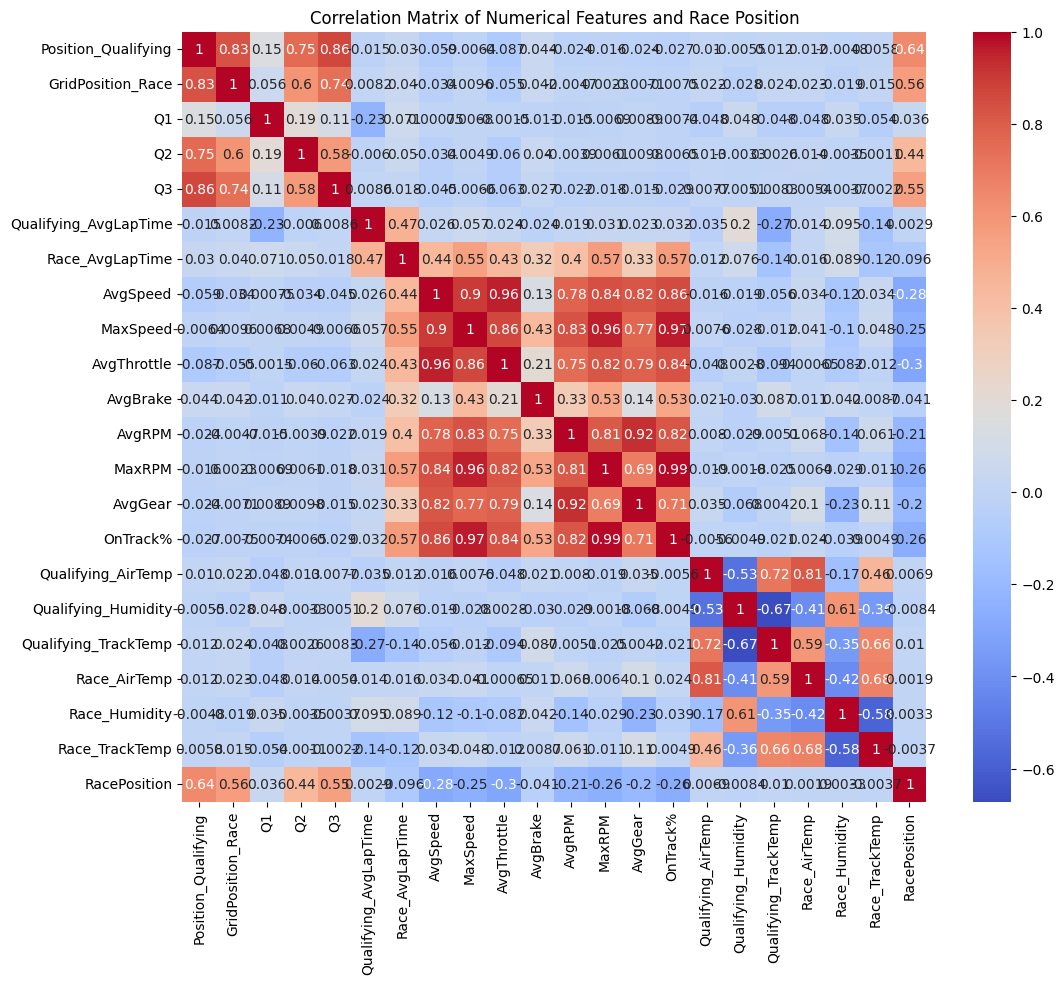

In [44]:
# Get the original features (before preprocessing)
X_original = X_train.reset_index(drop=True)

# Add the target variable
X_original['RacePosition'] = y_train.reset_index(drop=True)

# Select only the numeric columns
numeric_cols = X_original.select_dtypes(include=['float64', 'int64']).columns

# Compute the correlation matrix using only numeric columns
corr_matrix = X_original[numeric_cols].corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features and Race Position')
plt.show()

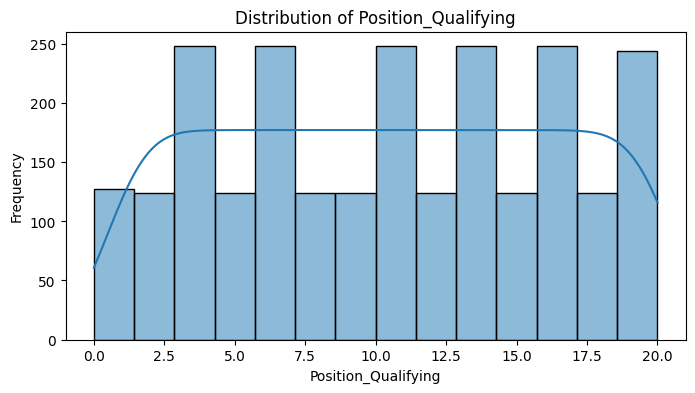

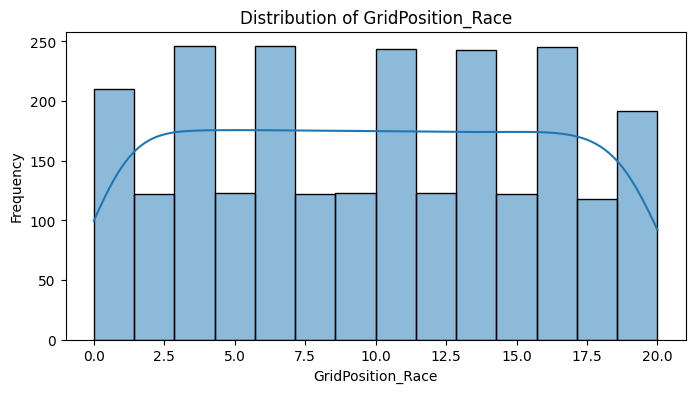

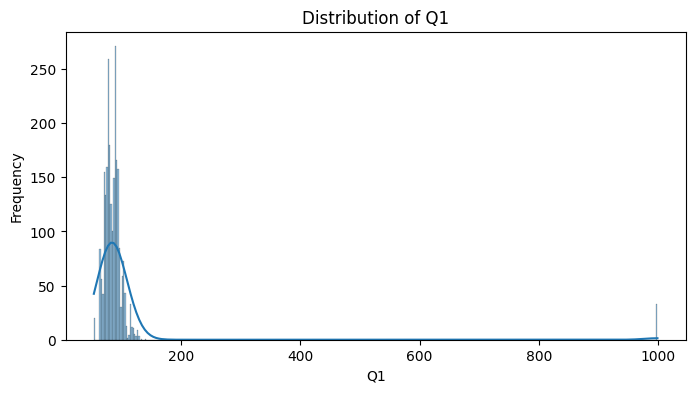

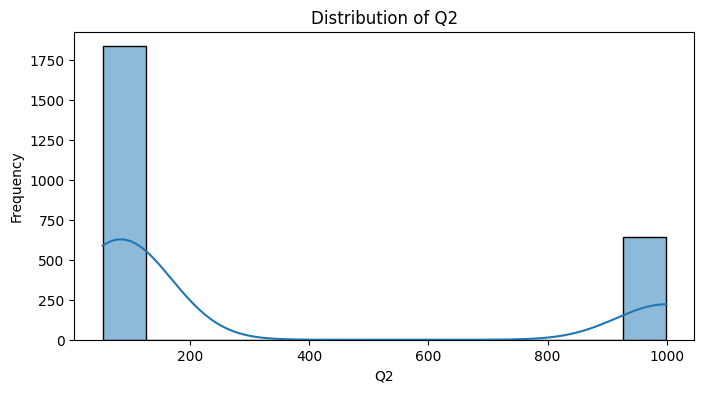

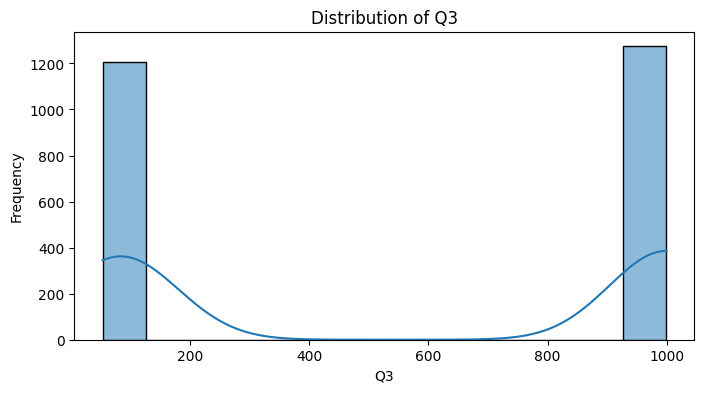

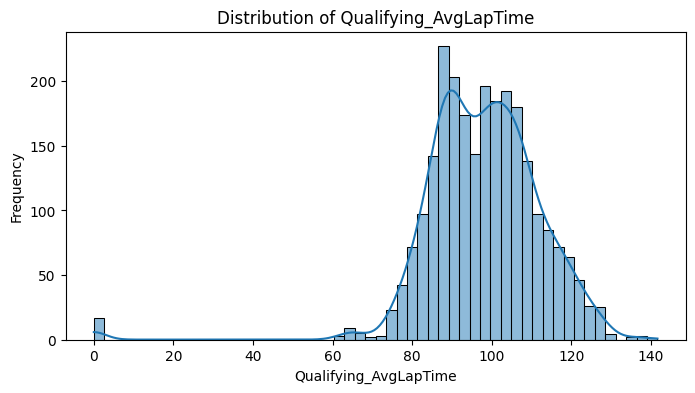

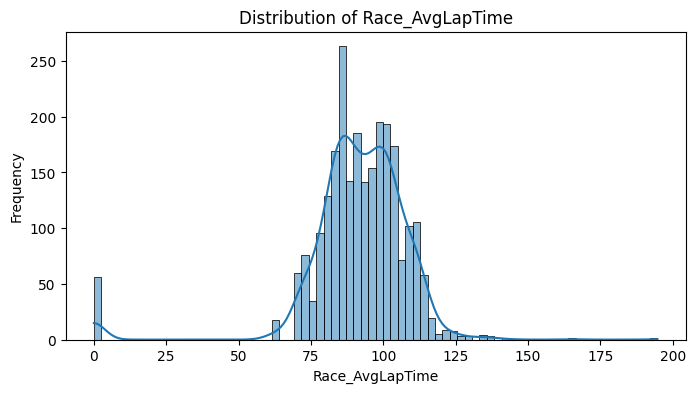

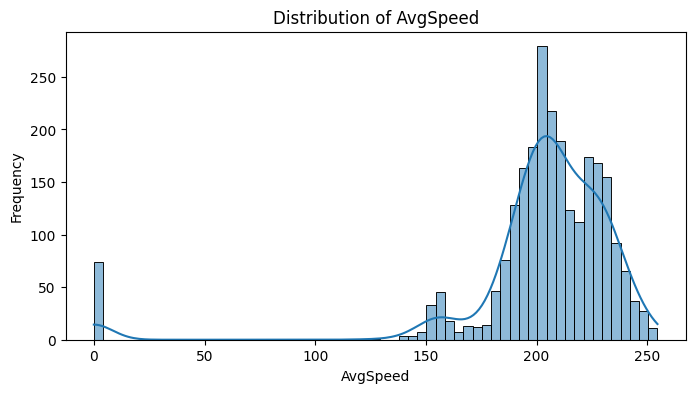

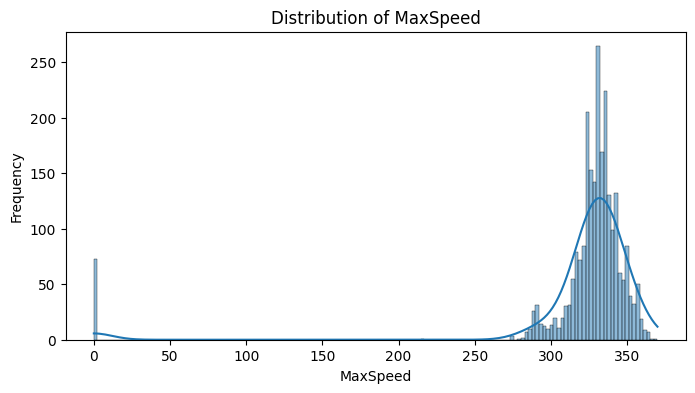

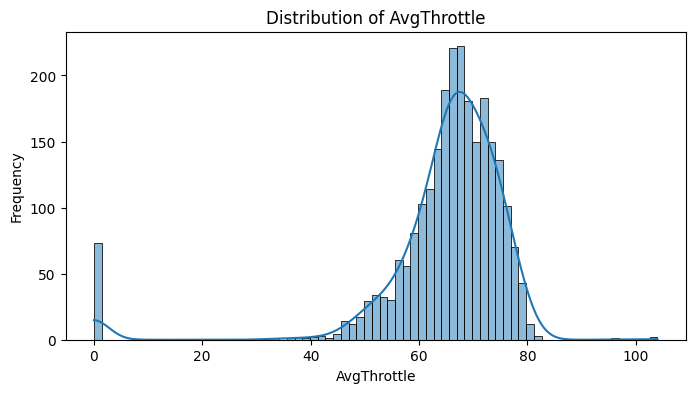

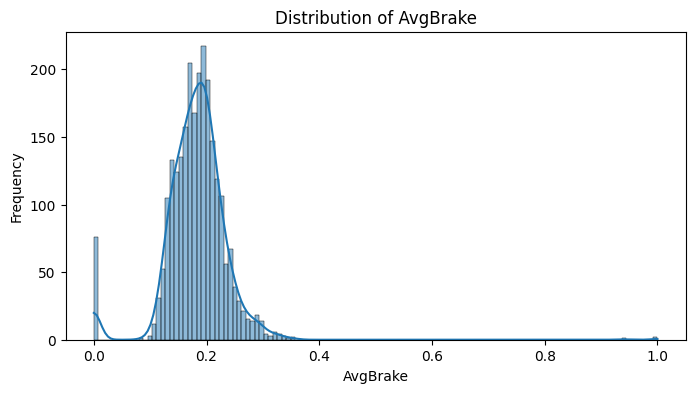

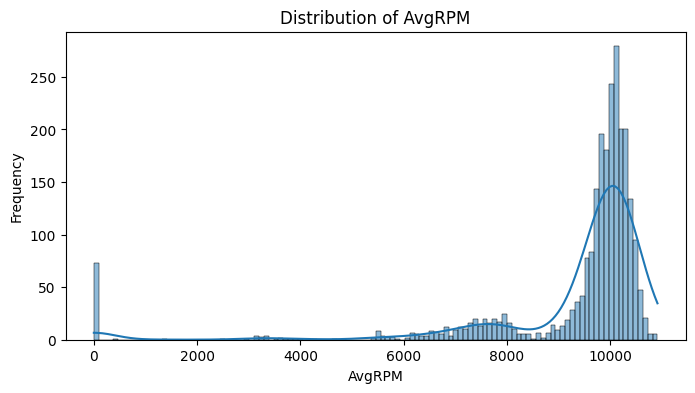

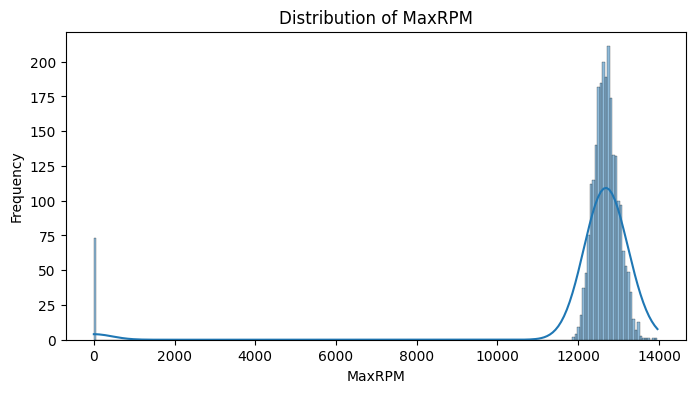

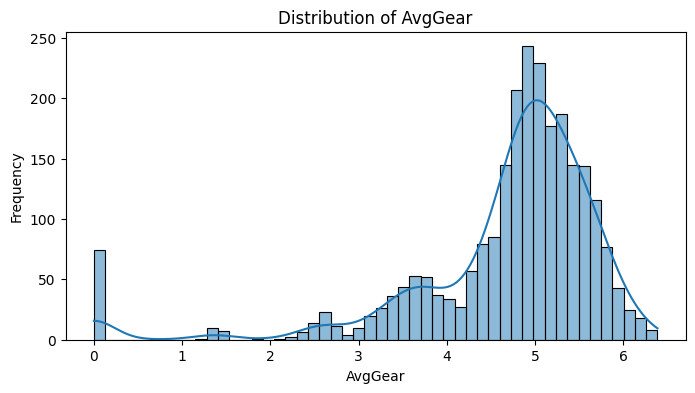

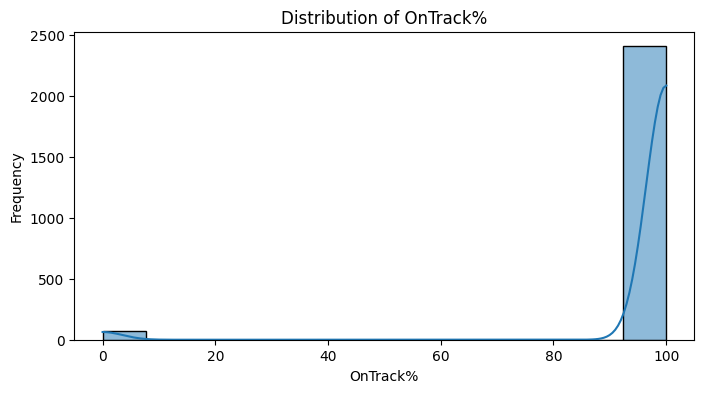

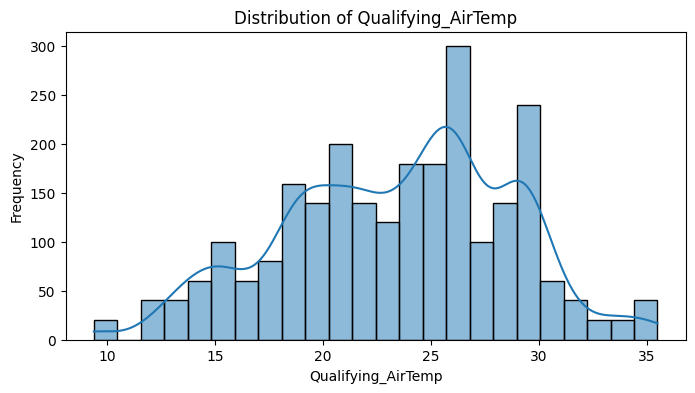

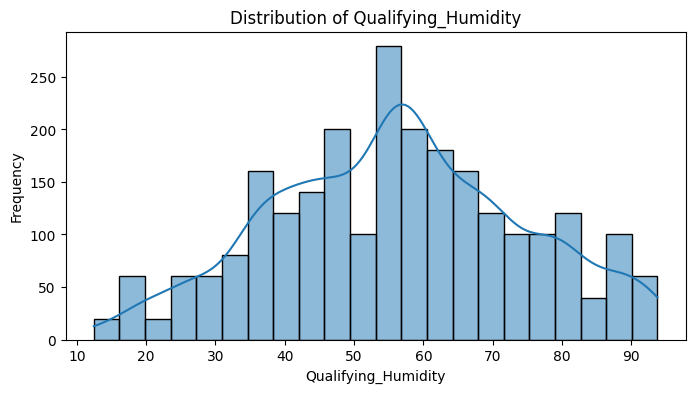

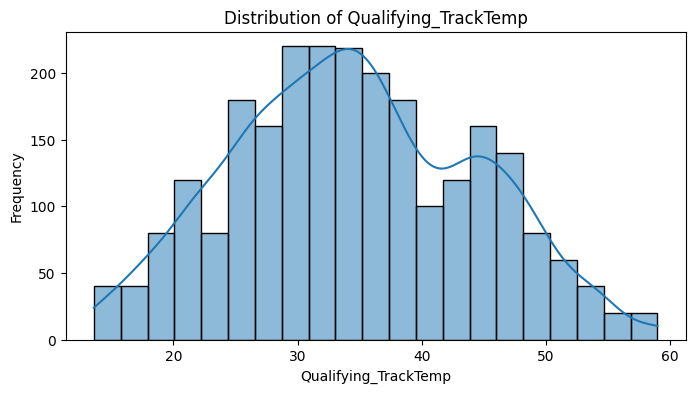

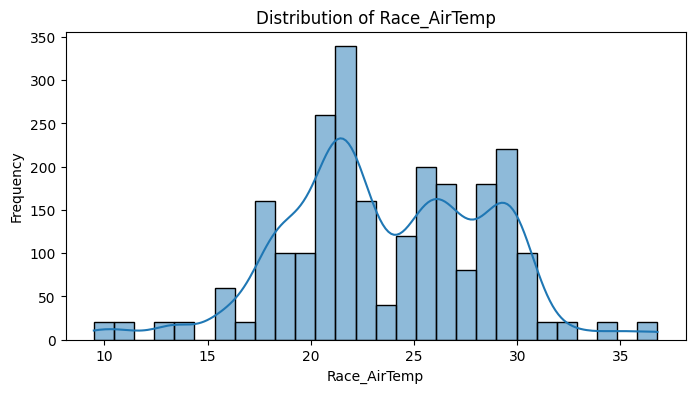

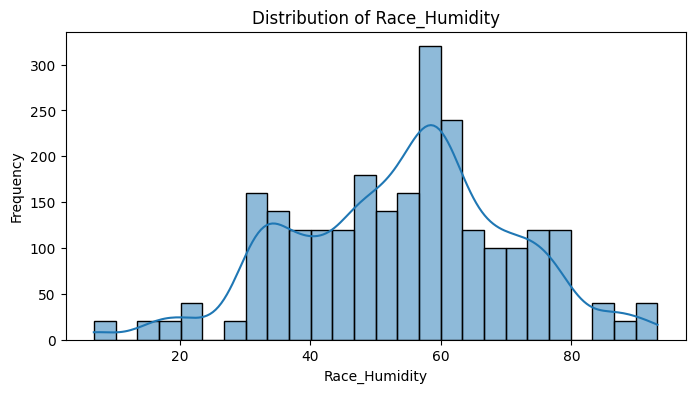

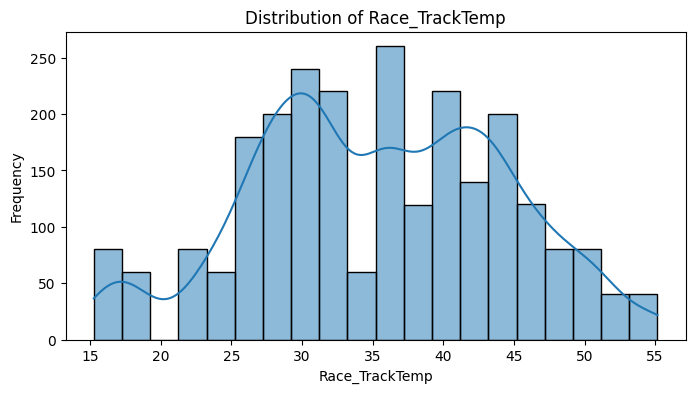

In [45]:
for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(full_data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()


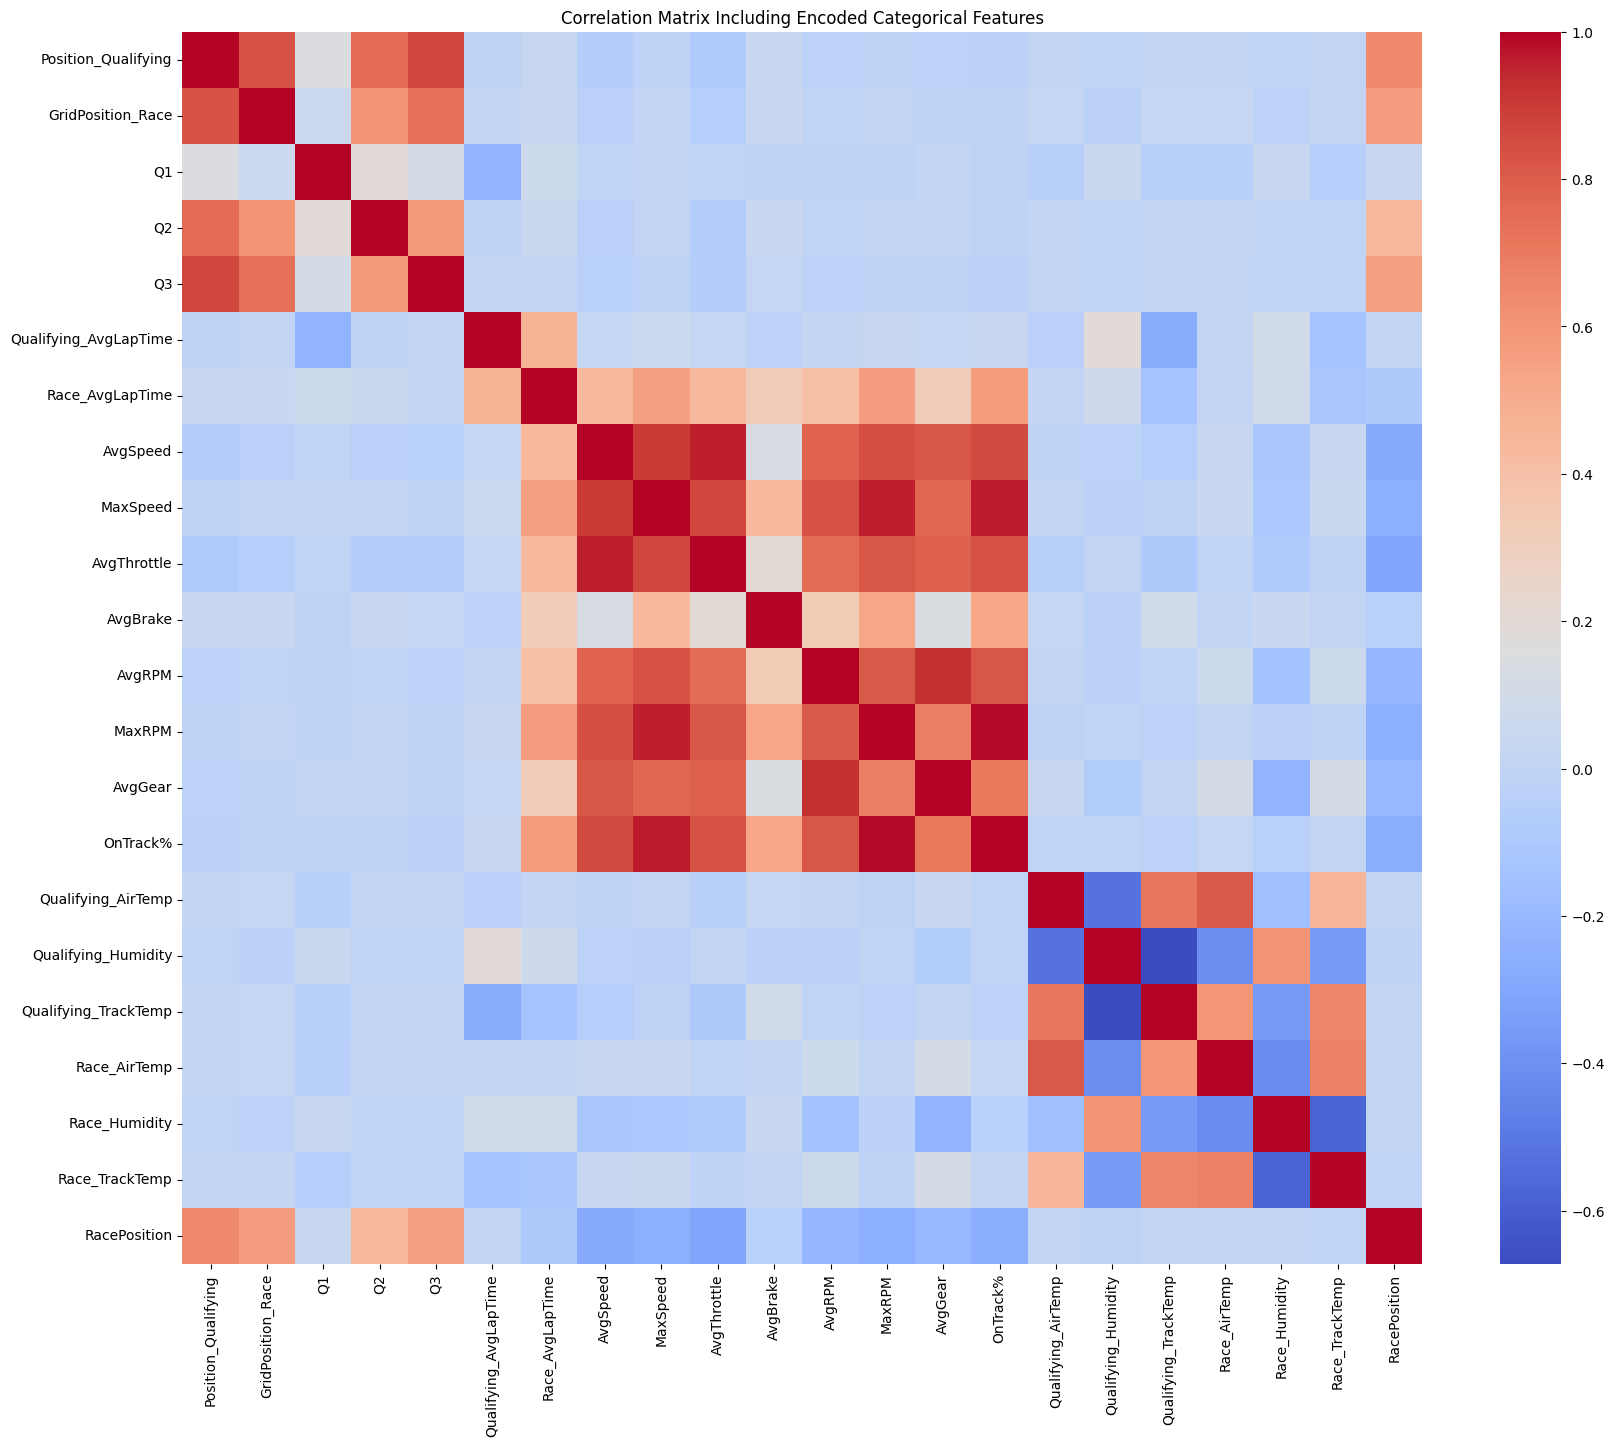

In [46]:
# Perform One-Hot Encoding on categorical columns
X_encoded = pd.get_dummies(X_original, columns=['TeamName_Race'], drop_first=True)

# Recalculate the list of numeric columns after encoding
numeric_cols = X_encoded.select_dtypes(include=['float64', 'int64']).columns

# Compute the correlation matrix using the encoded DataFrame
corr_matrix = X_encoded[numeric_cols].corr()

# Plot the correlation matrix
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix Including Encoded Categorical Features')
plt.show()


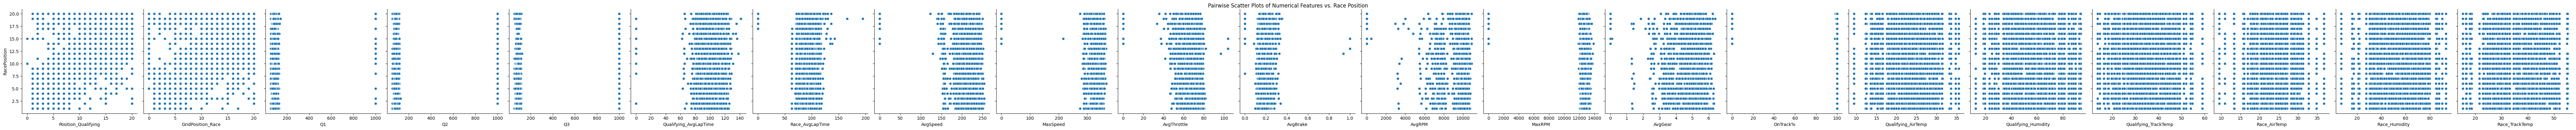

In [47]:
# List of numerical features
numerical_features = numeric_cols.drop('RacePosition')  # Exclude the target variable

# Create pair plots
sns.pairplot(X_original, x_vars=numerical_features, y_vars='RacePosition', height=4, aspect=1)
plt.suptitle('Pairwise Scatter Plots of Numerical Features vs. Race Position', y=1.02)
plt.show()


In [48]:

# Since learning_curve works with scikit-learn estimators, wrap the model
estimator = KerasRegressor(build_fn=lambda: model, epochs=10, batch_size=32, verbose=0)
estimator.model = model

train_sizes, train_scores, test_scores = learning_curve(
    estimator, X_train_processed, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

# Calculate mean and standard deviation
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training MAE")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation MAE")
plt.title('Learning Curves')
plt.xlabel('Training examples')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.show()


ValueError: 
All the 25 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/scikeras/wrappers.py", line 925, in _fit
    X, y = self._initialize(X, y)
           ^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/scikeras/wrappers.py", line 853, in _initialize
    X, y = self._validate_data(X, y, reset=True)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/scikeras/wrappers.py", line 1733, in _validate_data
    return super()._validate_data(X=X, y=y, reset=reset, y_numeric=True)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/scikeras/wrappers.py", line 626, in _validate_data
    X, y = check_X_y(
           ^^^^^^^^^^
  File "/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1318, in check_X_y
    y = _check_y(y, multi_output=multi_output, y_numeric=y_numeric, estimator=estimator)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1328, in _check_y
    y = check_array(
        ^^^^^^^^^^^^
  File "/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1064, in check_array
    _assert_all_finite(
  File "/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/sklearn/utils/validation.py", line 123, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/sklearn/utils/validation.py", line 172, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input y contains NaN.


In [49]:
# Since learning_curve works with scikit-learn estimators, wrap the model
estimator_v2 = KerasRegressor(build_fn=lambda: model_v2, epochs=10, batch_size=32, verbose=0)
estimator_v2.model = model_v2

train_sizes_v2, train_scores_v2, test_scores_v2 = learning_curve(
    estimator_v2, X_train_processed, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

# Calculate mean and standard deviation
train_scores_mean_v2 = -np.mean(train_scores_v2, axis=1)
train_scores_std_v2 = np.std(train_scores_v2, axis=1)
test_scores_mean_v2 = -np.mean(test_scores_v2, axis=1)
test_scores_std_v2 = np.std(test_scores_v2, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes_v2, train_scores_mean_v2 - train_scores_std_v2,
                 train_scores_mean_v2 + train_scores_std_v2, alpha=0.1, color="r")
plt.fill_between(train_sizes_v2, test_scores_mean_v2 - test_scores_std_v2,
                 test_scores_mean_v2 + test_scores_std_v2, alpha=0.1, color="g")
plt.plot(train_sizes_v2, train_scores_mean_v2, 'o-', color="r", label="Training MAE")
plt.plot(train_sizes_v2, test_scores_mean_v2, 'o-', color="g", label="Cross-validation MAE")
plt.title('Learning Curves')
plt.xlabel('Training examples')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.show()

ValueError: 
All the 25 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/scikeras/wrappers.py", line 925, in _fit
    X, y = self._initialize(X, y)
           ^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/scikeras/wrappers.py", line 853, in _initialize
    X, y = self._validate_data(X, y, reset=True)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/scikeras/wrappers.py", line 1733, in _validate_data
    return super()._validate_data(X=X, y=y, reset=reset, y_numeric=True)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/scikeras/wrappers.py", line 626, in _validate_data
    X, y = check_X_y(
           ^^^^^^^^^^
  File "/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1318, in check_X_y
    y = _check_y(y, multi_output=multi_output, y_numeric=y_numeric, estimator=estimator)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1328, in _check_y
    y = check_array(
        ^^^^^^^^^^^^
  File "/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1064, in check_array
    _assert_all_finite(
  File "/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/sklearn/utils/validation.py", line 123, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/sklearn/utils/validation.py", line 172, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input y contains NaN.


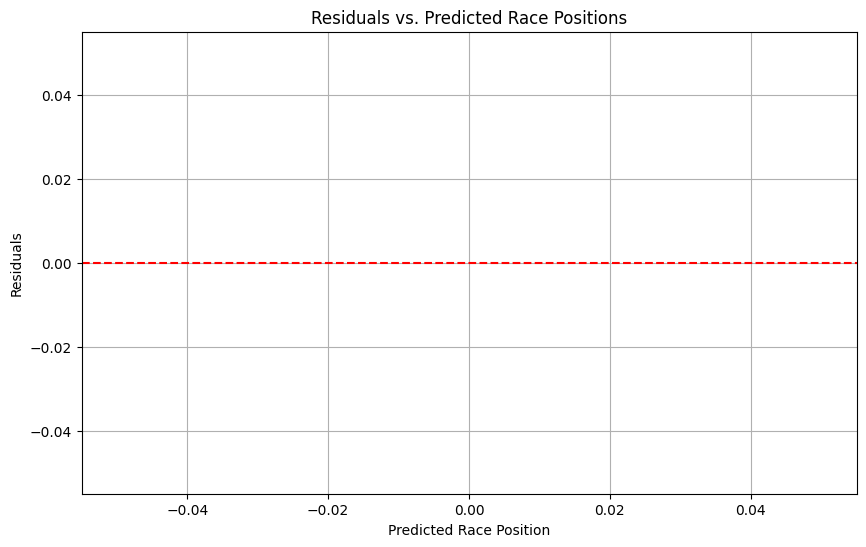

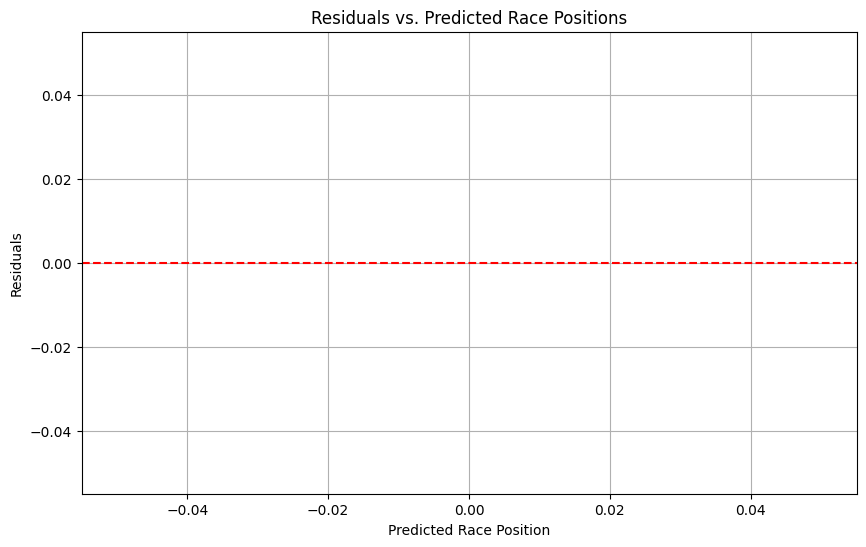

In [50]:
# Calculate residuals
residuals = y_test - y_pred
residuals_v2 = y_test - y_pred_v2

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.title('Residuals vs. Predicted Race Positions')
plt.xlabel('Predicted Race Position')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_v2, residuals_v2, alpha=0.7)
plt.title('Residuals vs. Predicted Race Positions')
plt.xlabel('Predicted Race Position')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

In [51]:
# Convert y_test and y_pred to DataFrames
y_test_df = y_test.reset_index(drop=True).to_frame(name='ActualRacePosition')
y_pred_df = pd.DataFrame(y_pred, columns=['PredictedRacePosition'])
y_pred_v2_df = pd.DataFrame(y_pred_v2, columns=['PredictedRacePosition'])


In [52]:
# Get the original test features
X_test_original = X_test.reset_index(drop=True)

# Combine the data
results_df = pd.concat([X_test_original, y_test_df, y_pred_df], axis=1)
results_df_v2 = pd.concat([X_test_original, y_test_df, y_pred_v2_df], axis=1)

In [53]:
# Extract driver and event information from the full dataset
full_data.reset_index(drop=True, inplace=True)

# Combine X and y
full_dataset = pd.concat([X.reset_index(drop=True), y.reset_index(drop=True)], axis=1)

# Add driver and event information to the full dataset
full_dataset['DriverNumber'] = full_data['DriverNumber'].values
full_dataset['Abbreviation_Race'] = full_data['Abbreviation_Race'].values
full_dataset['EventName'] = full_data['EventName'].values

In [54]:
# Extract the corresponding rows from the full dataset using test indices
test_info = full_dataset.iloc[test_idx].reset_index(drop=True)

# Combine the test info with the results
results_df = pd.concat(
    [test_info[['DriverNumber', 'Abbreviation_Race', 'EventName']].reset_index(drop=True),
     y_test.reset_index(drop=True).to_frame(name='ActualRacePosition'),
     pd.DataFrame(y_pred, columns=['PredictedRacePosition']).reset_index(drop=True)],
    axis=1
)

results_df_v2 = pd.concat(
    [test_info[['DriverNumber', 'Abbreviation_Race', 'EventName']].reset_index(drop=True),
     y_test.reset_index(drop=True).to_frame(name='ActualRacePosition'),
     pd.DataFrame(y_pred_v2, columns=['PredictedRacePosition']).reset_index(drop=True)],
    axis=1
)

In [55]:
# Remove duplicate columns if any
results_df = results_df.loc[:, ~results_df.columns.duplicated()]
results_df_v2 = results_df_v2.loc[:, ~results_df_v2.columns.duplicated()]

In [56]:
# Sort the results by EventName and ActualRacePosition
results_df.sort_values(['EventName', 'ActualRacePosition'], inplace=True)
results_df_v2.sort_values(['EventName', 'ActualRacePosition'], inplace=True)

# Display the table
print(results_df.to_string(index=False))
print(results_df_v2.to_string(index=False))


DriverNumber Abbreviation_Race                   EventName  ActualRacePosition  PredictedRacePosition
          23               ALB 70th Anniversary Grand Prix                 1.0                    NaN
          26               KVY 70th Anniversary Grand Prix                 1.0                    NaN
          63               RUS 70th Anniversary Grand Prix                 3.0                    NaN
           6               LAT 70th Anniversary Grand Prix                 5.0                    NaN
          18               STR 70th Anniversary Grand Prix                 6.0                    NaN
          31               OCO 70th Anniversary Grand Prix                 6.0                    NaN
           5               VET 70th Anniversary Grand Prix                 6.0                    NaN
          44               HAM 70th Anniversary Grand Prix                 7.0                    NaN
          55               SAI 70th Anniversary Grand Prix                 7.0    

/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data.sort_values('ActualRacePosition', inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data_v2.sort_values('ActualRacePosition', inplace=True)


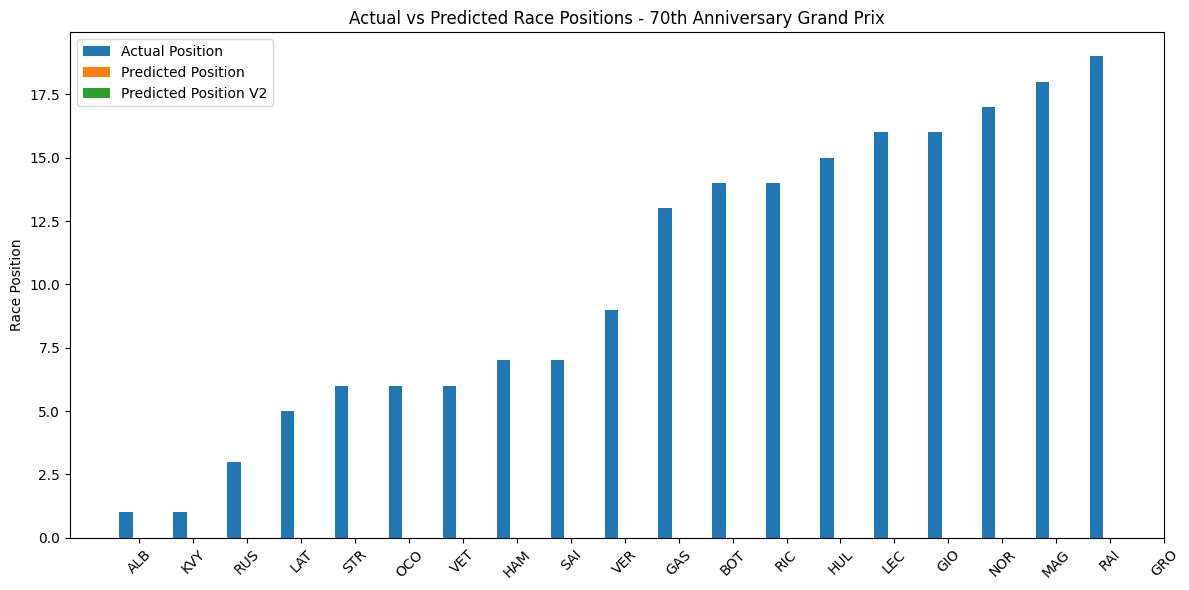

/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data.sort_values('ActualRacePosition', inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data_v2.sort_values('ActualRacePosition', inplace=True)


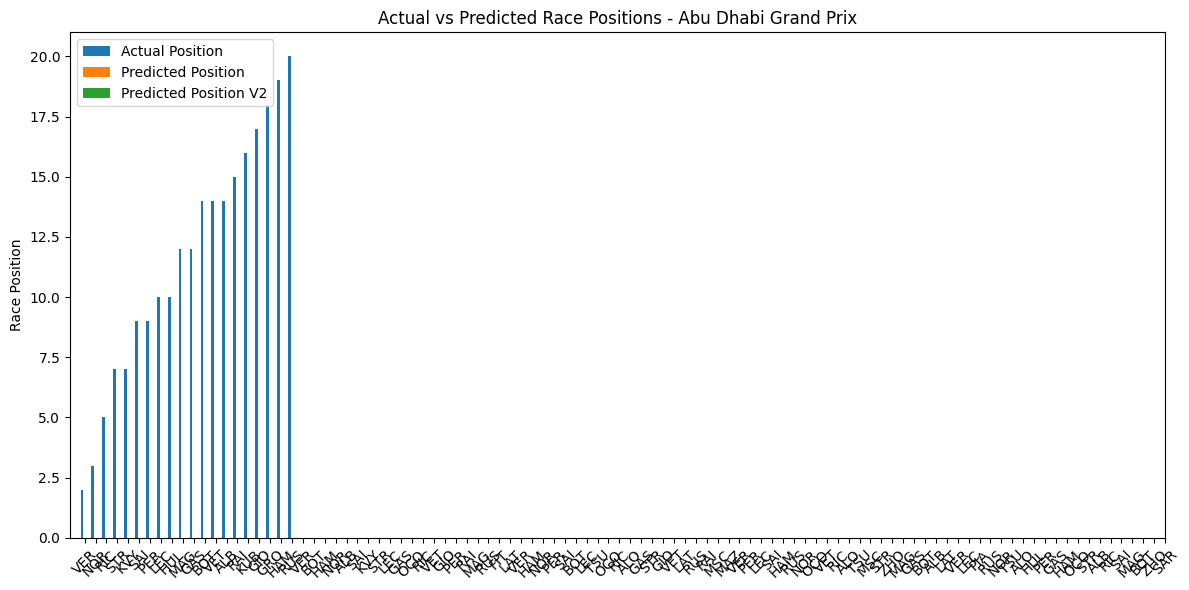

/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data.sort_values('ActualRacePosition', inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data_v2.sort_values('ActualRacePosition', inplace=True)


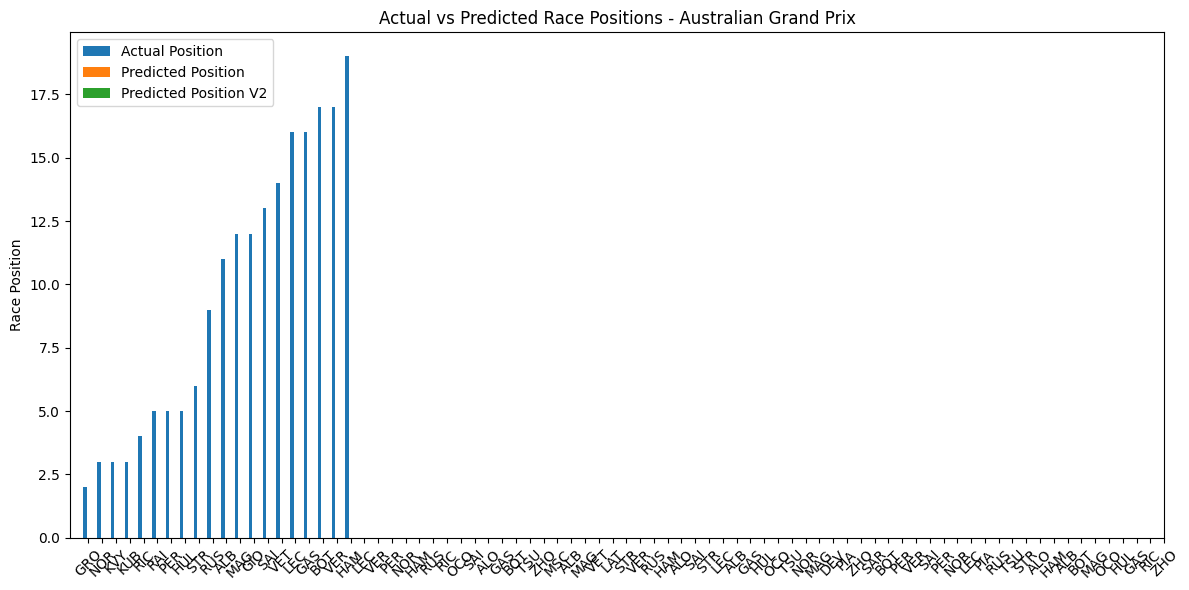

/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data.sort_values('ActualRacePosition', inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data_v2.sort_values('ActualRacePosition', inplace=True)


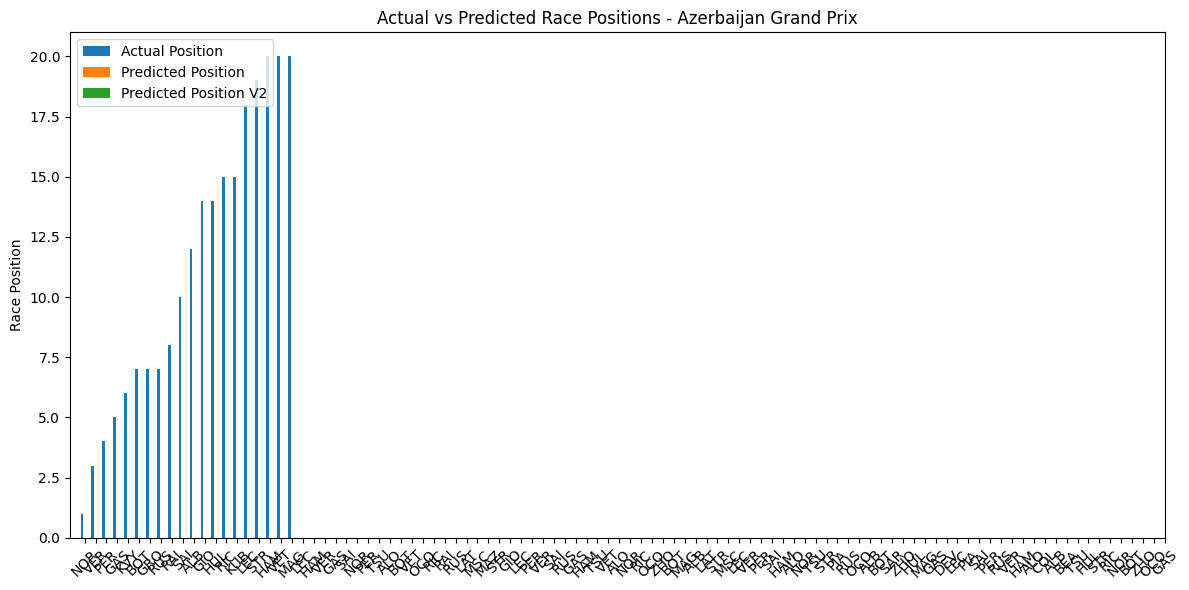

/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data.sort_values('ActualRacePosition', inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data_v2.sort_values('ActualRacePosition', inplace=True)


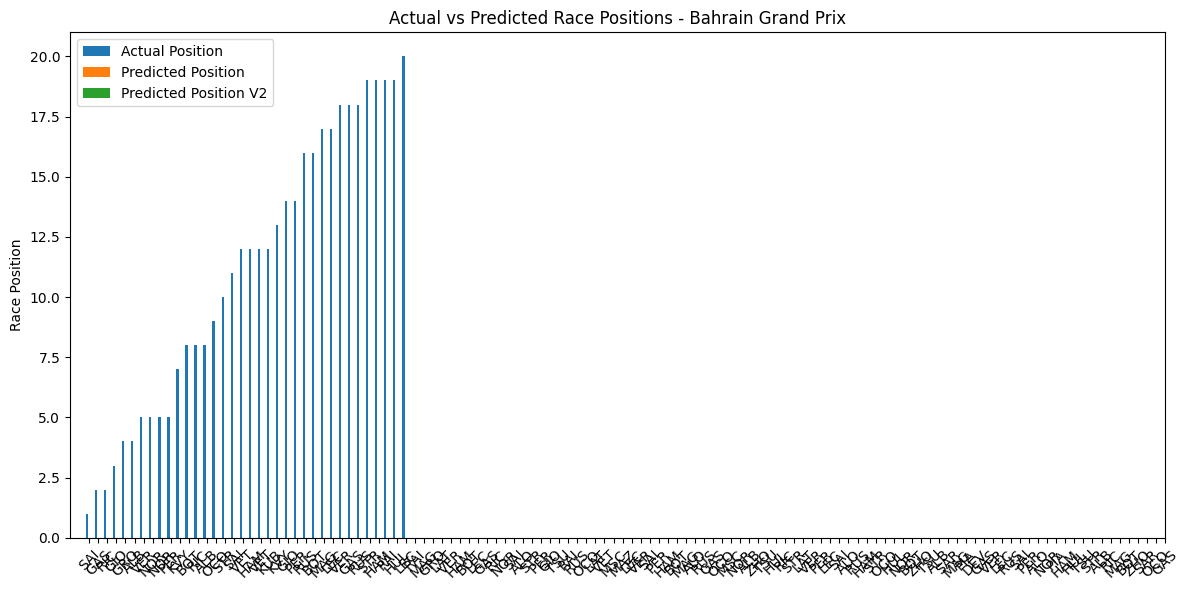

/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data.sort_values('ActualRacePosition', inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data_v2.sort_values('ActualRacePosition', inplace=True)


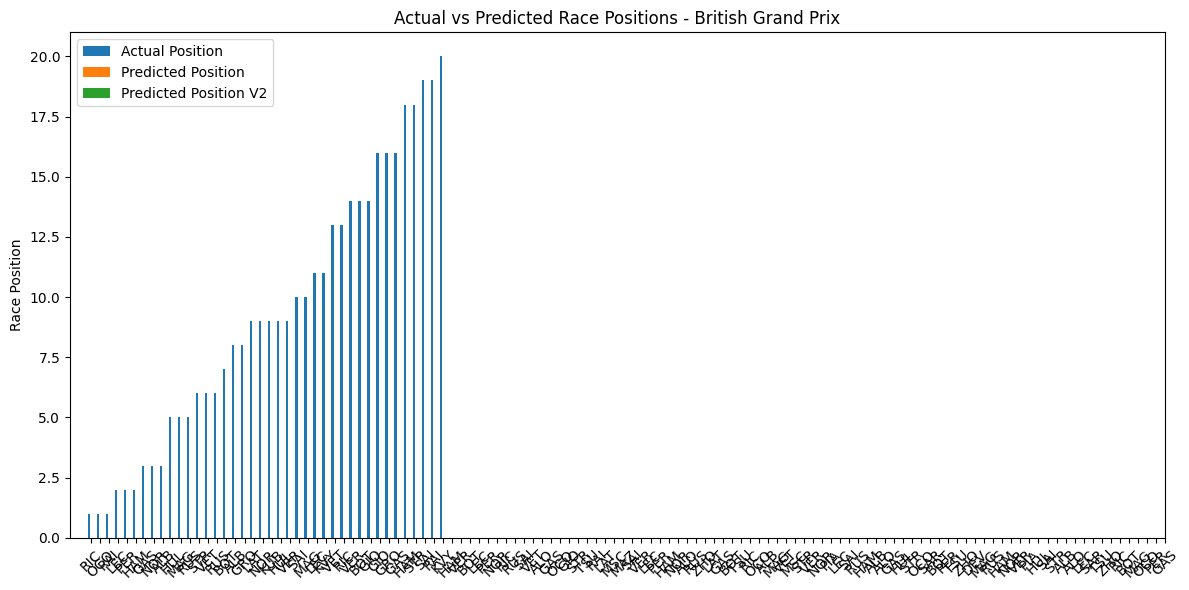

/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data.sort_values('ActualRacePosition', inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data_v2.sort_values('ActualRacePosition', inplace=True)


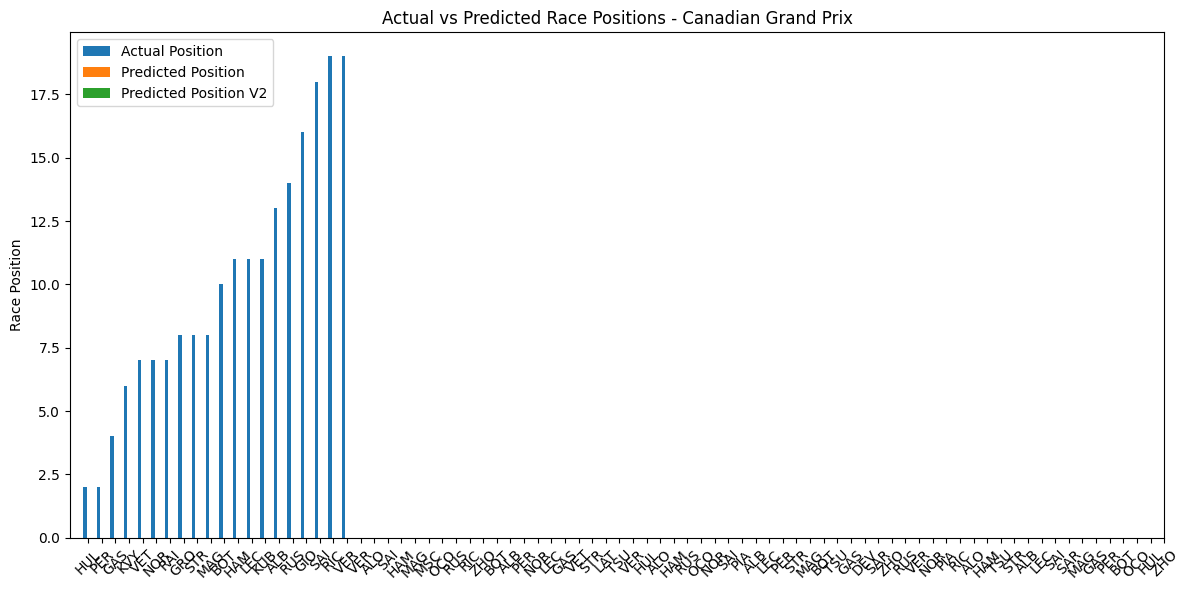

/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data.sort_values('ActualRacePosition', inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data_v2.sort_values('ActualRacePosition', inplace=True)


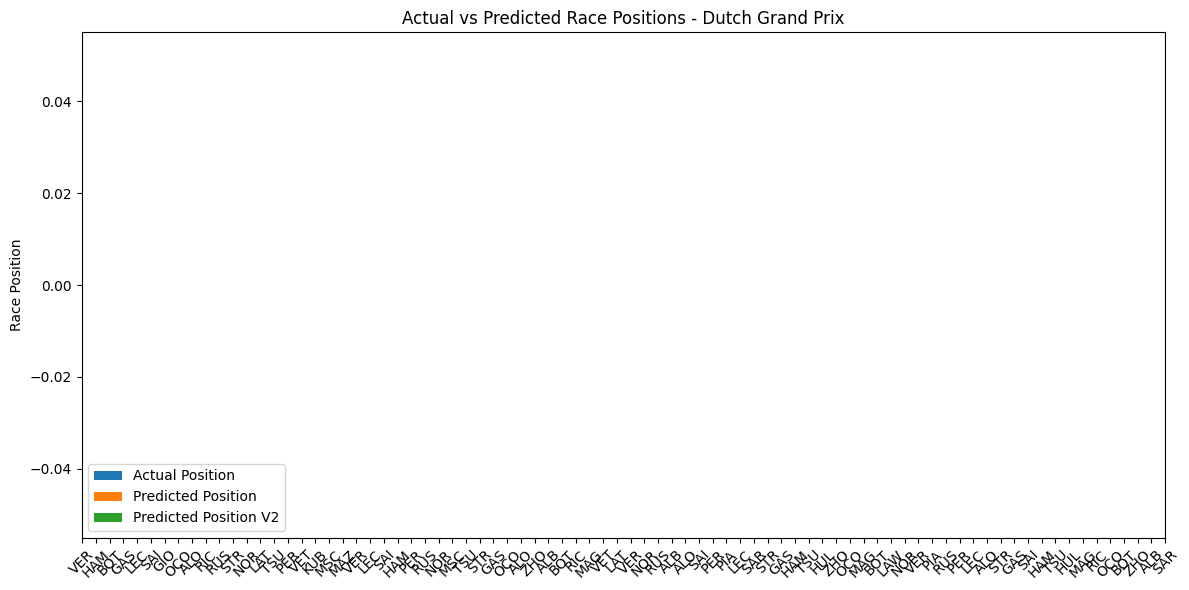

/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data.sort_values('ActualRacePosition', inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data_v2.sort_values('ActualRacePosition', inplace=True)


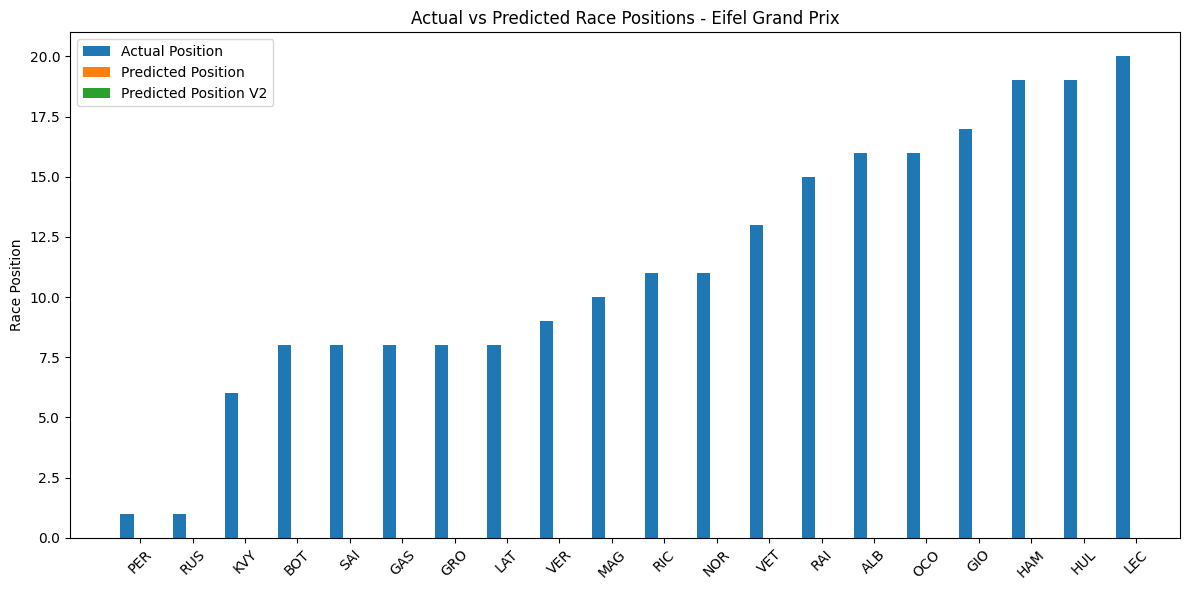

/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data.sort_values('ActualRacePosition', inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data_v2.sort_values('ActualRacePosition', inplace=True)


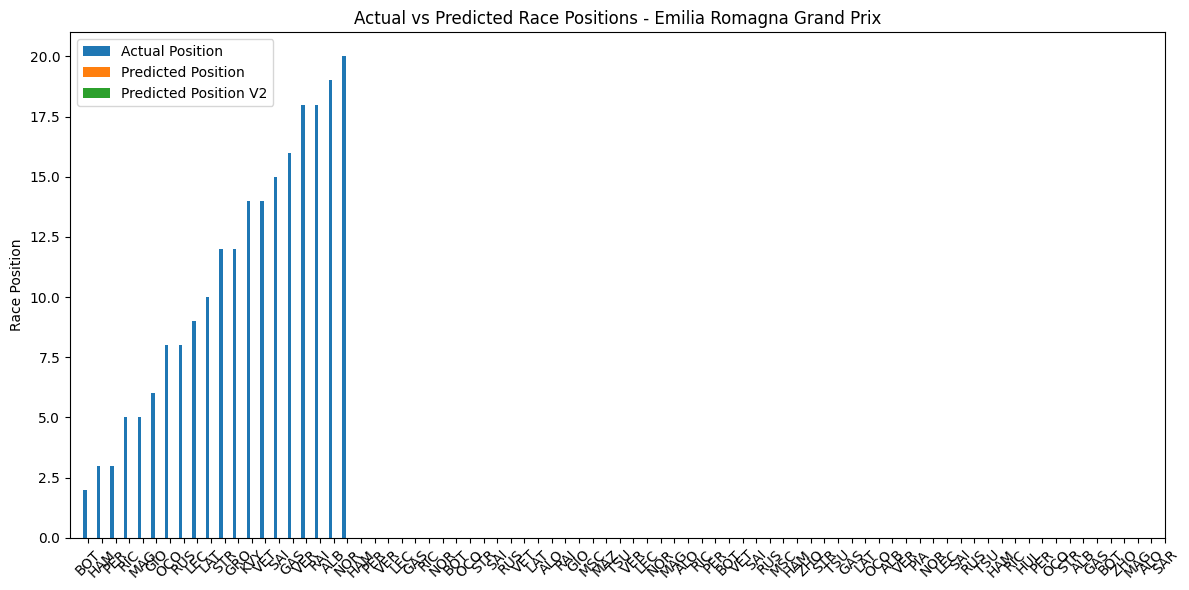

/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data.sort_values('ActualRacePosition', inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data_v2.sort_values('ActualRacePosition', inplace=True)


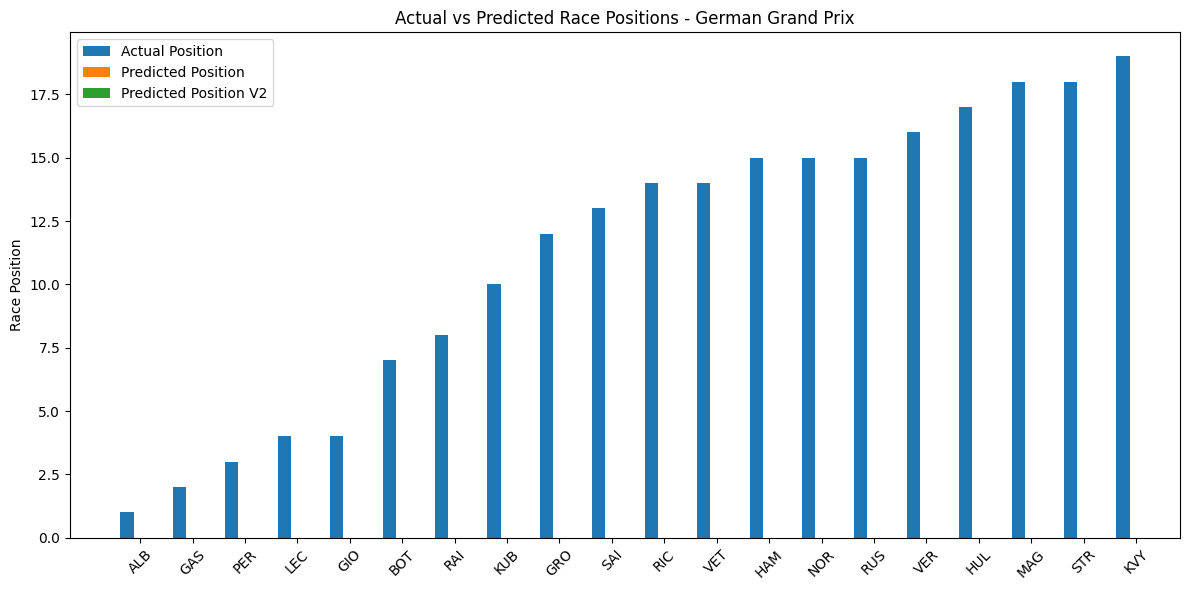

/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data.sort_values('ActualRacePosition', inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data_v2.sort_values('ActualRacePosition', inplace=True)


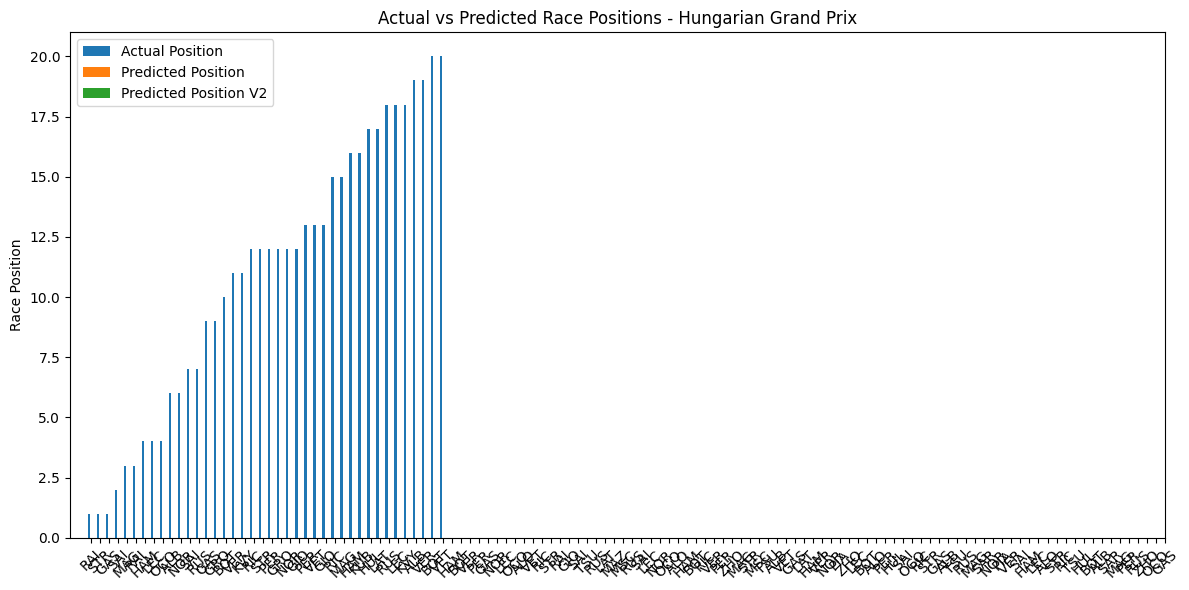

/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data.sort_values('ActualRacePosition', inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data_v2.sort_values('ActualRacePosition', inplace=True)


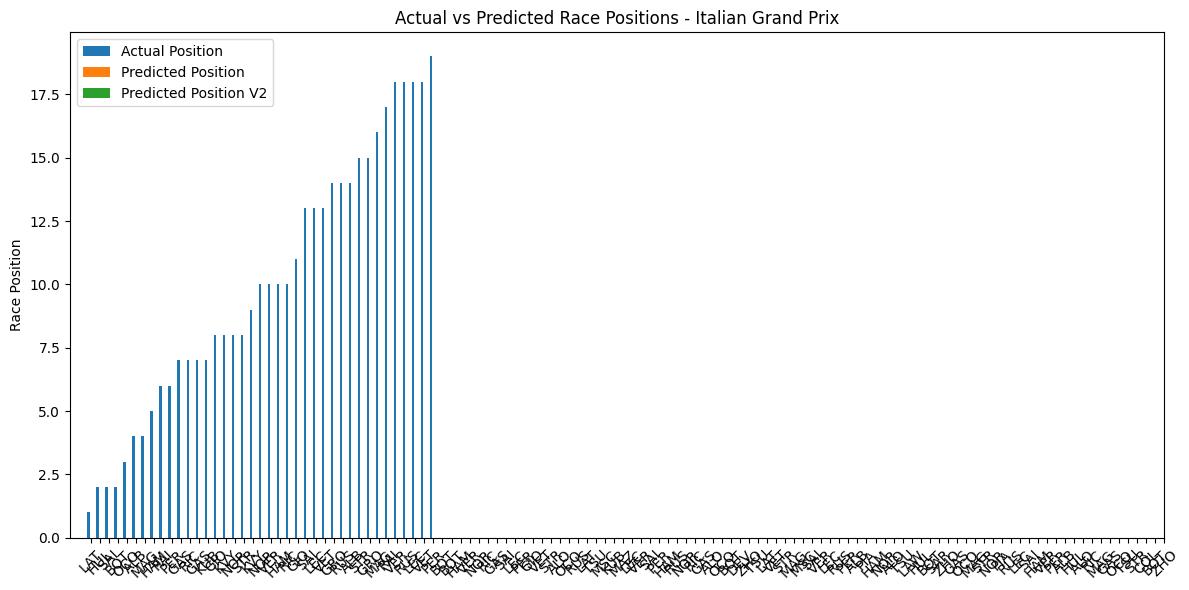

/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data.sort_values('ActualRacePosition', inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data_v2.sort_values('ActualRacePosition', inplace=True)


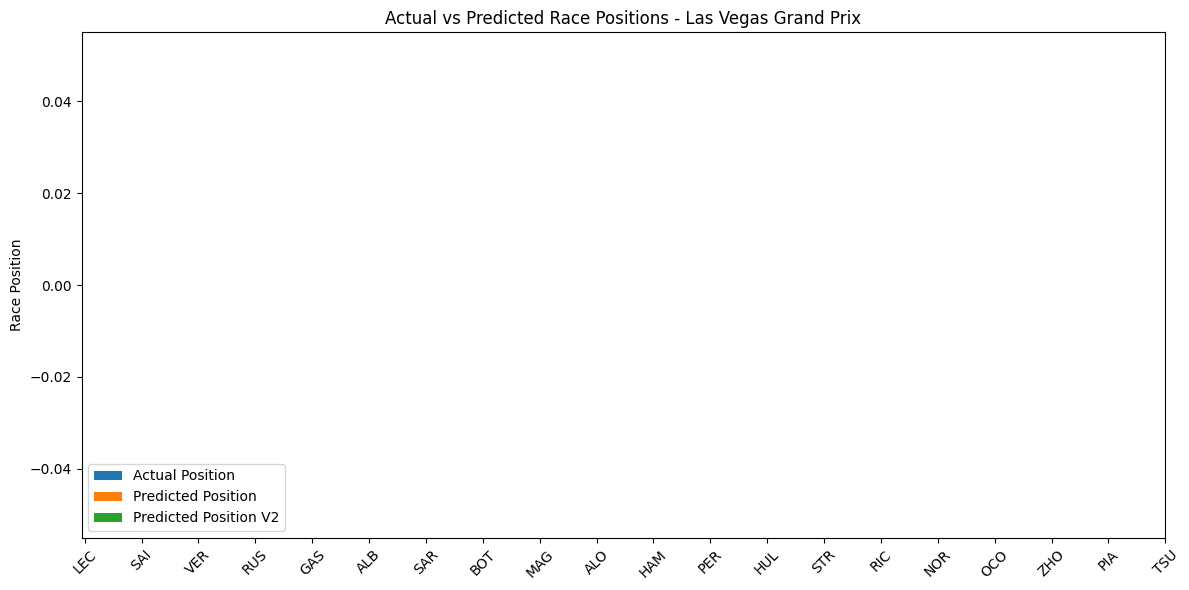

/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data.sort_values('ActualRacePosition', inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data_v2.sort_values('ActualRacePosition', inplace=True)


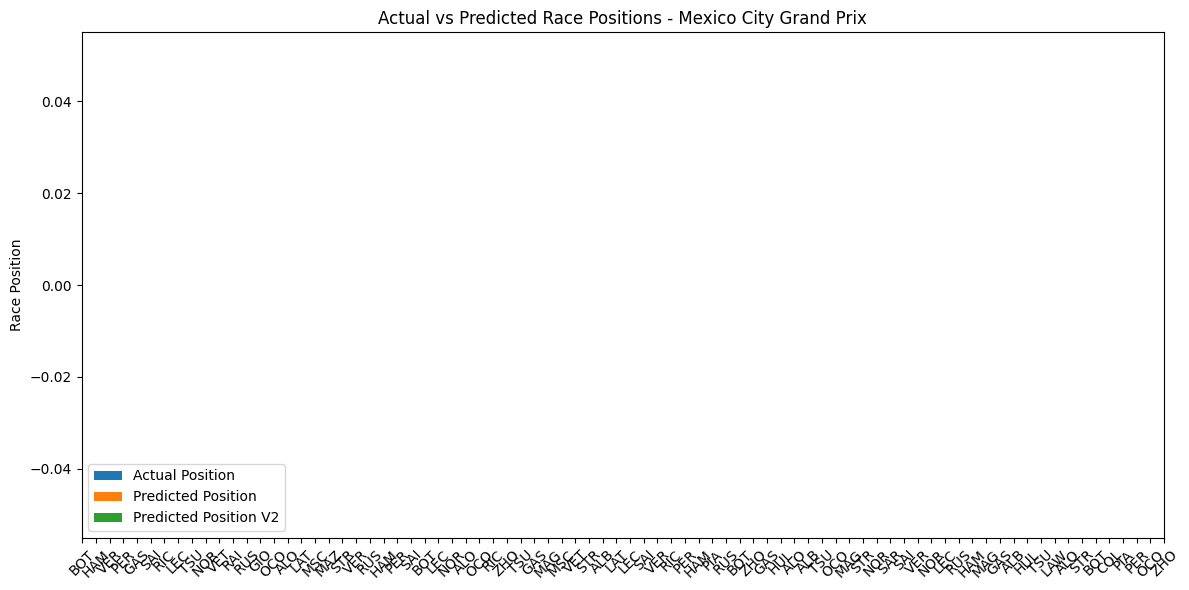

/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data.sort_values('ActualRacePosition', inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data_v2.sort_values('ActualRacePosition', inplace=True)


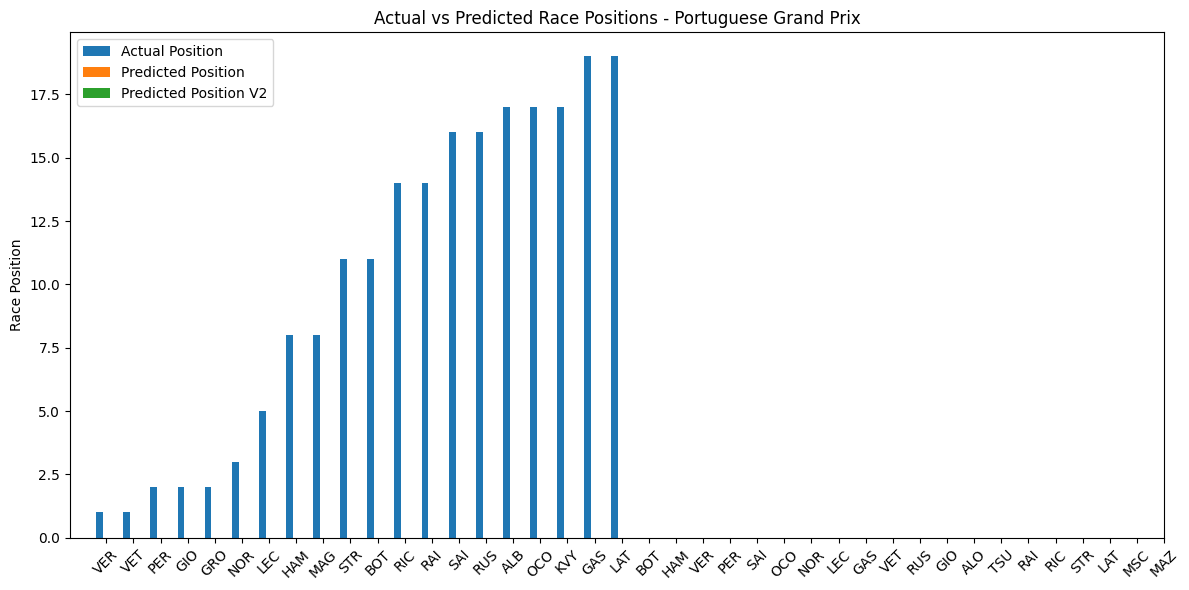

/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data.sort_values('ActualRacePosition', inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data_v2.sort_values('ActualRacePosition', inplace=True)


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data.sort_values('ActualRacePosition', inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data_v2.sort_values('ActualRacePosition', inplace=True)


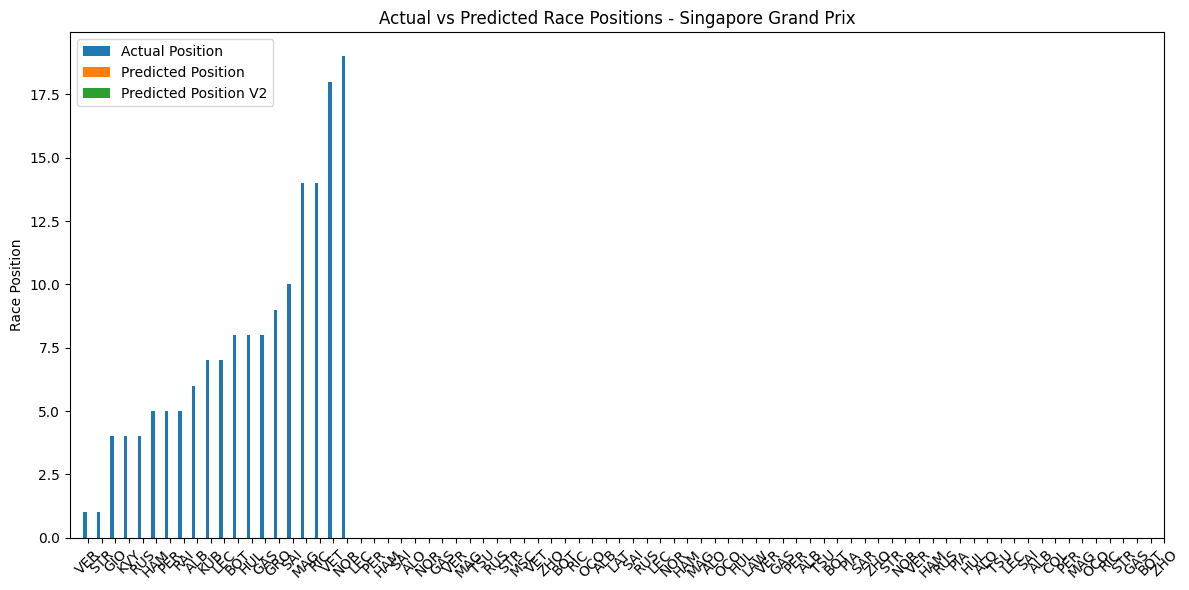

/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data.sort_values('ActualRacePosition', inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data_v2.sort_values('ActualRacePosition', inplace=True)


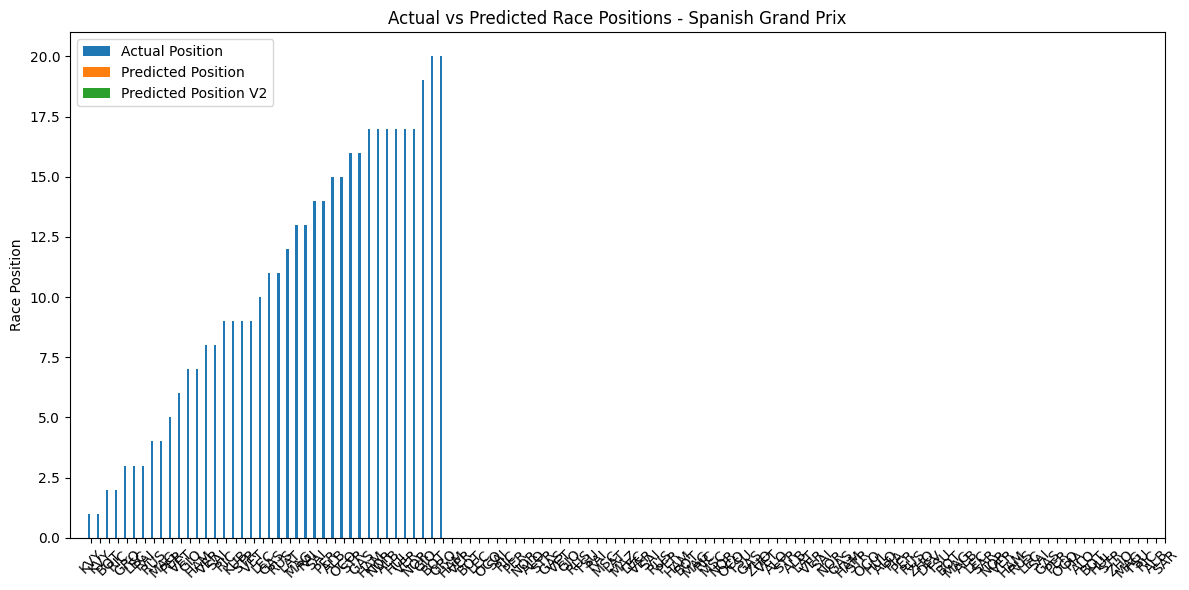

/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data.sort_values('ActualRacePosition', inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data_v2.sort_values('ActualRacePosition', inplace=True)


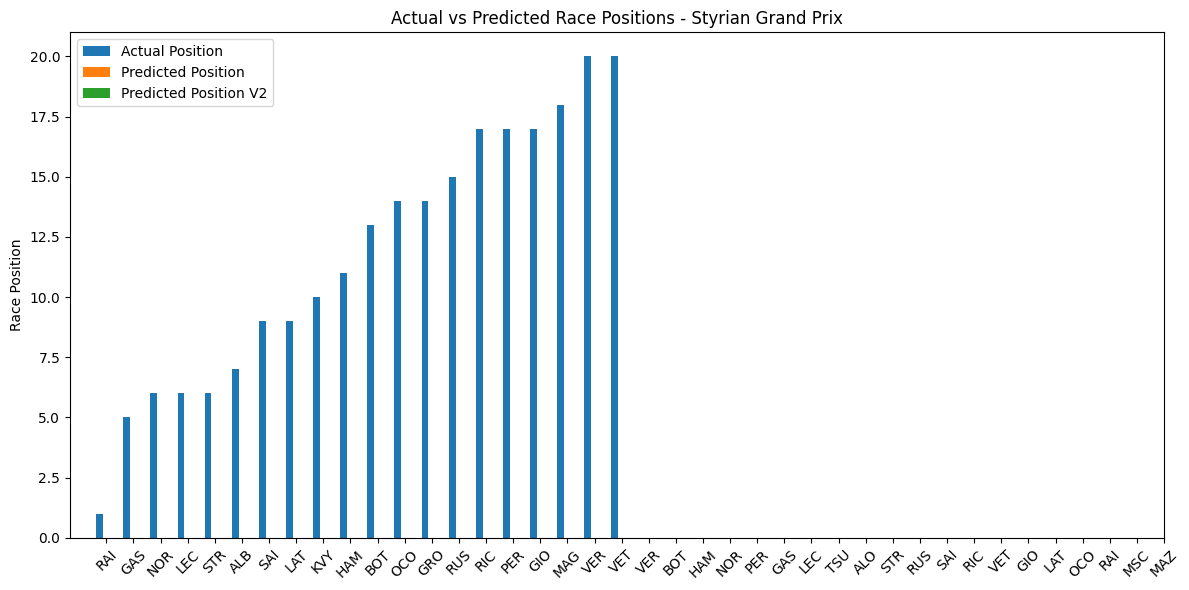

/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data.sort_values('ActualRacePosition', inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data_v2.sort_values('ActualRacePosition', inplace=True)


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data.sort_values('ActualRacePosition', inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_38946/545900420.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data_v2.sort_values('ActualRacePosition', inplace=True)


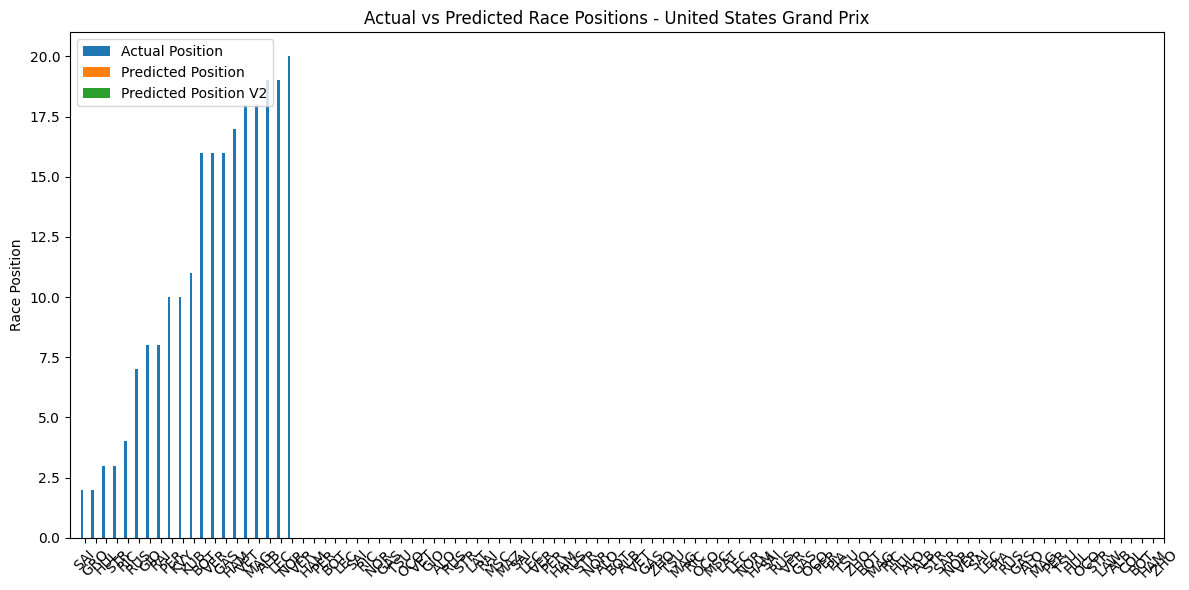

In [57]:
# Get the list of unique events in the test set
events = results_df['EventName'].unique()

for event in events:
    # Filter data for the current event
    event_data = results_df[results_df['EventName'] == event]
    event_data_v2 = results_df_v2[results_df_v2['EventName'] == event]

    # Sort by actual race position
    event_data.sort_values('ActualRacePosition', inplace=True)
    event_data_v2.sort_values('ActualRacePosition', inplace=True)

    # Create a bar plot
    x = np.arange(len(event_data))  # Driver indices
    width = 0.25  # Adjusted width of the bars

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width, event_data['ActualRacePosition'], width, label='Actual Position')  # Shifted left
    rects2 = ax.bar(x, event_data['PredictedRacePosition'], width, label='Predicted Position')  # Centered
    rects3 = ax.bar(x + width, event_data_v2['PredictedRacePosition'], width, label='Predicted Position V2')  # Shifted right

    # Add labels and titles
    ax.set_ylabel('Race Position')
    ax.set_title(f'Actual vs Predicted Race Positions - {event}')
    ax.set_xticks(x)
    ax.set_xticklabels(event_data['Abbreviation_Race'], rotation=45)
    ax.legend()

    plt.tight_layout()
    plt.show()
